# LangGraph

 > Disclaimer: This post has been translated to English using a machine translation model. Please, let me know if you find any mistakes.

`LangGraph` is a low-level orchestration framework for building controllable agents

While `LangChain` provides integrations and components to accelerate the development of LLM applications, the `LangGraph` library enables the orchestration of agents, offering customizable architectures, long-term memory, and `human in the loop` to reliably handle complex tasks.

> In this post, we are going to disable `LangSmith`, which is a graph debugging tool. We will disable it to avoid adding more complexity to the post and focus solely on `LangGraph`

## How does `LangGraph` work?

`LangGraph` is based on three components:

* **Nodes**: Represent the processing units of the application, such as calling an LLM or a tool. They are Python functions that run when the node is called.
* Take the state as input
* Perform some operation
* Return the updated state
* **Edges**: Represent the transitions between nodes. They define the logic of how the graph will be executed, that is, which node will run after another. They can be:
* Directs: Go from one node to another
* Conditionals: Depend on a condition
* **State**: Represents the state of the application, that is, it contains all the necessary information for the application. It is maintained during the execution of the application. It is defined by the user, so you need to think carefully about what will be stored in it.

![LangGraph concept](https://pub-fb664c455eca46a2ba762a065ac900f7.r2.dev/langgraph_concept.webp)

All `LangGraph` graphs start from a `START` node and end at an `END` node.

## Installation of LangGraph

To install `LangGraph`, you can use pip:

```bash
pip install -U langgraph
```

or install from Conda:

```bash
conda install langgraph
```

## Installation of Hugging Face and Anthropic Modules

We are going to use a language model from `Hugging Face`, so we need to install its langgraph package.

```bash
pip install langchain-huggingface
```

For one part we are going to use `Sonnet 3.7`, then we will explain why. So we also install the `Anthropic` package.

```bash
pip install langchain_anthropic
```

## Hugging Face API Key

We are going to use `Qwen/Qwen2.5-72B-Instruct` through `Hugging Face Inference Endpoints`, so we need an API KEY.

To be able to use the `Inference Endpoints` of HuggingFace, the first thing you need is to have an account on HuggingFace. Once you have one, you need to go to [Access tokens](https://huggingface.co/settings/keys) in your profile settings and generate a new token.

We need to give it a name. In my case, I'm going to call it `langgraph` and enable the permission `Make calls to inference providers`. It will create a token that we need to copy.

To manage the token, we are going to create a file in the same path where we are working called `.env` and we will put the token we have copied into the file in the following way:

``` bash
HUGGINGFACE_LANGGRAPH="hf_...."
```

Now, to obtain the token, we need to have `dotenv` installed, which we install through

```bash
pip install python-dotenv
```

We run the following

In [1]:
import os
import dotenv

dotenv.load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

Now that we have a token, we create a client. For this, we need to have the `huggingface_hub` library installed. We install it using conda or pip.

``` bash
pip install --upgrade huggingface_hub
```

o

``` bash
conda install -c conda-forge huggingface_hub
```

Now we have to choose which model we are going to use. You can see the available models on the [Supported models](https://huggingface.co/docs/api-inference/supported-models) page of the `Inference Endpoints` documentation from Hugging Face.

We are going to use `Qwen2.5-72B-Instruct` which is a very good model.

In [2]:
MODEL = "Qwen/Qwen2.5-72B-Instruct"

Now we can create the client

In [3]:
from huggingface_hub import InferenceClient

client = InferenceClient(api_key=HUGGINGFACE_TOKEN, model=MODEL)
client

<InferenceClient(model='Qwen/Qwen2.5-72B-Instruct', timeout=None)>

We do a test to see if it works

In [4]:
message = [
	{ "role": "user", "content": "Hola, qué tal?" }
]

stream = client.chat.completions.create(
	messages=message, 
	temperature=0.5,
	max_tokens=1024,
	top_p=0.7,
	stream=False
)

response = stream.choices[0].message.content
print(response)

¡Hola! Estoy bien, gracias por preguntar. ¿Cómo estás tú? ¿En qué puedo ayudarte hoy?


## API KEY of Anthropic

## Create a basic chatbot

We are going to create a simple chatbot using `LangGraph`. This chatbot will respond directly to the user's messages. Although it is simple, it will serve to see the basic concepts of building graphs with `LangGraph`.

As its name suggests, `LangGraph` is a library for handling graphs. So we start by creating a graph [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph).

A `StateGraph` defines the structure of our chatbot as a `state machine`. We will add `nodes` to our graph to represent the `llm`s, `tool`s, and `functions`, where the `llm`s can make use of these `tool`s and `functions`; and we add `edges` to specify how the bot should transition between those `nodes`.

So we start by creating a `StateGraph` that needs a `State` class to handle the graph state. Since we are now going to create a simple chatbot, we only need to handle a list of messages in the state.

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

The function [add_messages](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages) combines two lists of messages.

New message lists will arrive, so they will be added to the existing message list. Each message list contains an `ID`, so they are added with this `ID`. This ensures that messages are only added, not replaced, unless a new message has the same `ID` as an existing one, in which case it is replaced.

`add_messages` is a [reducer function](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers), it is a function responsible for updating the state.

The graph `graph_builder` that we have created receives a state `State` and returns a new state `State`. Additionally, it updates the list of messages.

> **Concept**
>
> When defining a graph, the first step is to define its `State`. The `State` includes the graph schema and the `reducer functions` that handle state updates.
>
> In our example, `State` is of type `TypedDict` (typed dictionary) with one key: `messages`.
>
> `add_messages` is a `reducer function` used to add new messages to the list instead of overwriting them in the list. If a state key does not have a `reducer function`, each value coming from that key will overwrite the previous values.
>
> `add_messages` is a `reducer function` of langgraph, but we will be able to create our own

Now we are going to add the `chatbot` node to the graph. Nodes represent units of work. Usually, they are regular `Python` functions.

We add a node with the `add_node` method that receives the name of the node and the function that will be executed.

So we are going to create an LLM with HuggingFace, then we will create a chat model with `LangChain` that will reference the created LLM. Once we have defined a chat model, we define the function that will be executed in the node of our graph. That function will make a call to the created chat model and return the result.

Lastly, we are going to add a node with the chatbot function to the graph

In [4]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Define the chatbot function
def chatbot_function(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot_node", chatbot_function)

We have used [ChatHuggingFace](https://python.langchain.com/api_reference/huggingface/chat_models/langchain_huggingface.chat_models.huggingface.ChatHuggingFace.html#langchain_huggingface.chat_models.huggingface.ChatHuggingFace) which is a chat of the type [BaseChatModel](https://python.langchain.com/api_reference/core/language_models/langchain_core.language_models.chat_models.BaseChatModel.html#langchain_core.language_models.chat_models.BaseChatModel) that is a base chat type of `LangChain`. Once we created the `BaseChatModel`, we created the function `chatbot_function` that will run when the node is executed. And finally, we created the node `chatbot_node` and indicated that it has to execute the function `chatbot_function`.

> **Notice**
>
> The node function `chatbot_function` takes the state `State` as input and returns a dictionary that contains an update to the list `messages` for the key `messages`. This is the basic pattern for all functions of the node `LangGraph`.

The `reducer function` of our graph `add_messages` will add the response messages from the `llm` to any message that is already in the state.

Next, we add an `entry` node. This tells our graph where to start its work each time we run it.

In [5]:
from langgraph.graph import START

graph_builder.add_edge(START, "chatbot_node")

Similarly, we add a `finish` node. This indicates to the graph that each time this node is executed, it can finish the job.

In [6]:
from langgraph.graph import END

graph_builder.add_edge("chatbot_node", END)

We have imported `START` and `END` which can be found in [constants](https://langchain-ai.github.io/langgraph/reference/constants/) and are the first and the last node of our graph.

Normally they are virtual nodes

Finally, we need to compile our graph. To do this, we use the graph construction method `compile()`. This creates a `CompiledGraph` that we can use to run our application.

In [7]:
graph = graph_builder.compile()

We can visualize the graph using the `get_graph` method and one of the "drawing" methods, such as `draw_ascii` or `draw_mermaid_png`. Each drawing method requires additional dependencies.

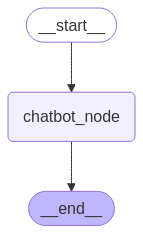

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Now we can test the chatbot!

> **Tip**
>
> In the following code block, you can exit the chat loop at any time by typing `quit`, `exit`, or `q`.

In [9]:
# Colors for the terminal
COLOR_GREEN = "\033[32m"
COLOR_YELLOW = "\033[33m"
COLOR_RESET = "\033[0m"


def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}{value['messages'][-1].content}")


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}Goodbye!")
            break
        
        events =stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: Hello
Assistant: Hello! It's nice to meet you. How can I assist you today? Whether you have questions, need information, or just want to chat, I'm here to help!
User: How are you doing?
Assistant: I'm just a computer program, so I don't have feelings, but I'm here and ready to help you with any questions or tasks you have! How can I assist you today?
User: Me well, I'm making a post about LangGraph, what do you think?
Assistant: LangGraph is an intriguing topic, especially if you're delving into the realm of graph-based models and their applications in natural language processing (NLP). LangGraph, as I understand, is a framework or tool that leverages graph theory to improve or provide a new perspective on NLP tasks such as text classification, information extraction, and semantic analysis. By representing textual information as graphs (nodes for entities and edges for relationships), it can offer a more nuanced understanding of the context and semantics in language data.

If you

**Congratulations!** You have built your first chatbot using `LangGraph`. This bot can engage in basic conversation by taking user input and generating responses using the `LLM` we defined.

We have been writing the code step by step, and it might not have been very clear. This was done to explain each part of the code, but now we are going to rewrite it, but in a different order, which looks clearer. That is, now that there's no need to explain each part of the code, we will group it differently to make it more clear.

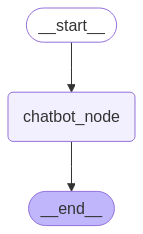

In [4]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login

from IPython.display import Image, display

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Function
def chatbot_function(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("chatbot_node", chatbot_function)

# Add edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile()

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

### More

All the `more` blocks are there if you want to delve deeper into `LangGraph`. If not, you can read everything without reading the `more` blocks.

#### State Typing

We have seen how to create an agent with a typed state using `TypedDict`, but we can create it with another typed type.

##### Typing with `TypeDict`

It's the form we've seen before, we type the state as a dictionary using Python's `TypeDict` typing. We pass a key and a value for each variable in our state.

``` python
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph

class State(TypedDict):
messages: Annotated[list, add_messages]
```

To access the messages, we do it as with any dictionary, using `state["messages"]`

##### Typing with `dataclass`

Another option is to use the Python `dataclass` typing

``` python
from dataclasses import dataclass
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph

@dataclass
class State:
messages: Annotated[list, add_messages]
```

As can be seen, it is similar to typing with dictionaries, but now, since the state is a class, we access the messages through `state.messages`

##### Typing with `Pydantic`

`Pydantic` is a widely used library for type hinting data in Python. It offers the possibility to add type checking. We are going to check that the message starts with `'User'`, `'Assistant'`, or `'System'`.

``` python
from pydantic import BaseModel, field_validator, ValidationError
from typing import Annotated
from langgraph.graph.message import add_messages

class State(BaseModel):
messages: Annotated[list, add_messages] # Should start by 'User', 'Assistant' or 'System'

@field_validator('messages')
@classmethod
def validate_messages(cls, value):
# Ensure the messages start with `User`, `Assistant` or `System`
if not value.startswith["'User'"] and not value.startswith["'Assistant'"] and not value.startswith["'System'"]:
raise ValueError("Message must start with 'User', 'Assistant' or 'System'")
return value

try:
state = PydanticState(messages=["Hello"])
except ValidationError as e:
print("Validation Error:", e)
```

#### Reducers

As we have said, we need to use a function of type `Reducer` to indicate how to update the state, since otherwise the state values will be overwritten.

Let's see an example of a graph where we don't use a `Reducer` function to indicate how to update the state

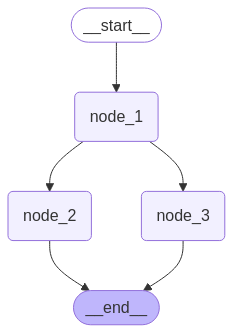

In [5]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

As we can see, we have defined a graph in which node 1 is executed first, followed by nodes 2 and 3. Let's run it to see what happens.

In [6]:
from langgraph.errors import InvalidUpdateError

try:
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")

---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


We get an error because first node 1 modifies the value of `foo` and then nodes 2 and 3 try to modify the value of `foo` in parallel, which results in an error.

So to avoid that, we use a function of type `Reducer` to indicate how to modify the state

##### Predefined reducers

We use the `Annotated` type to specify that it is a function of type `Reducer`. And we use the `add` operator to add a value to a list.

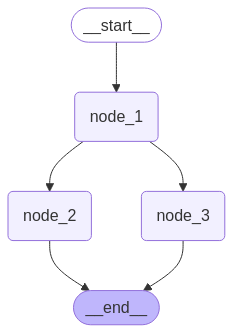

In [7]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We run it again to see what happens

In [8]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

As we see, we initialize the value of `foo` to 1, which is added to a list. Then node 1 adds 1 and appends it as a new value in the list, that is, it adds a 2. Finally, nodes 2 and 3 add one to the last value in the list, meaning both nodes get a 3 and both nodes append it to the end of the list, which is why the resulting list has two 3s at the end.

Let's consider the case where one branch has more nodes than another

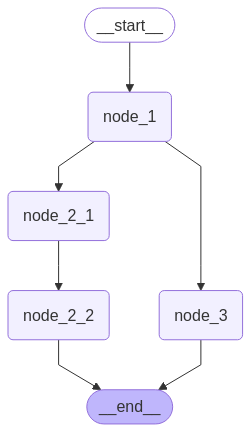

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2_1(state):
    print("---Node 2_1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2_2(state):
    print("---Node 2_2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2_1", node_2_1)
builder.add_node("node_2_2", node_2_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2_1")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2_1", "node_2_2")
builder.add_edge("node_2_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we now run the graph

In [3]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2_1---
---Node 3---
---Node 2_2---


{'foo': [1, 2, 3, 3, 4]}

What has happened is that first node 1 was executed, followed by node 2_1, then in parallel nodes 2_2 and 3, and finally the `END` node.

Since we have defined `foo` as a list of integers, and it is typed, if we initialize the state with `None` we get an error

In [9]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


Let's see how to fix it with `custom reducers`

##### Custom reducers

Sometimes we can't use a predefined `Reducer` and we have to create our own.

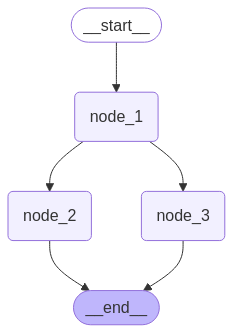

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import Annotated

def reducer_function(current_list, new_item: list | None):
    if current_list is None:
        current_list = []

    if new_item is not None:
        return current_list + new_item
    return current_list

class State(TypedDict):
    foo: Annotated[list[int], reducer_function]

def node_1(state):
    print("---Node 1---")
    if len(state['foo']) == 0:
        return {'foo': [0]}
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we now initialize the graph with a value of `None`, it won't give us an error.

In [22]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

---Node 1---
---Node 2---
---Node 3---


#### Multiple states

##### Private states

Suppose we want to hide state variables for whatever reason, because some variables only add noise or because we want to keep some variable private.

If we want to have a private state, we simply create it.

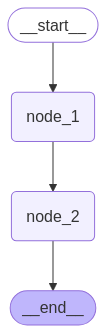

In [2]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class OverallState(TypedDict):
    public_var: int

class PrivateState(TypedDict):
    private_var: int

def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {"private_var": state['public_var'] + 1}

def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    return {"public_var": state['private_var'] + 1}

# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

As we can see, we have created the private state `PrivateState` and the public state `OverallState`. Each one has a private variable and a public variable. First, node 1 is executed, which modifies the private variable and returns it. Then, node 2 is executed, which modifies the public variable and returns it. Let's run the graph to see what happens.

In [2]:
graph.invoke({"public_var" : 1})

---Node 1---
---Node 2---


{'public_var': 3}

As we can see when running the graph, we pass the public variable `public_var` and get another public variable `public_var` at the output with the modified value, but the private variable `private_var` was never accessed.

##### Input and output states

We can define the input and output variables of the graph. Although internally the state may have more variables, we define which variables are inputs to the graph and which variables are outputs.

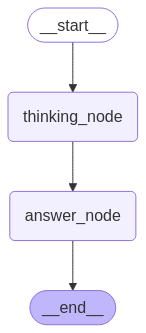

In [3]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState):
    return {"answer": "bye", "notes": "... his is name is Lance"}

def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Lance"}

graph = StateGraph(OverallState, input=InputState, output=OutputState)

graph.add_node("answer_node", answer_node)
graph.add_node("thinking_node", thinking_node)
graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In this case, the state has 3 variables, `question`, `answer` and `notes`. However, we define `question` as the input to the graph and `answer` as the output of the graph. Therefore, the internal state can have more variables, but they are not taken into account when invoking the graph. Let's run the graph to see what happens

In [4]:
graph.invoke({"question":"hi"})

{'answer': 'bye Lance'}

As we can see, we have added `question` to the graph and obtained `answer` at the output.

#### Context Handling

Let's revisit the code of the basic chatbot

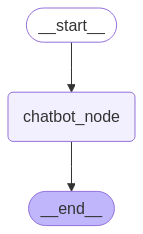

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Define the chatbot function
def chatbot_function(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot_node", chatbot_function)

# Connect nodes
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

Let's create a context that we will pass to the model

In [9]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


If we pass it to the graph, we will get the output

In [10]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's a great topic! Besides whales, there are several other fascinating ocean mammals you might want to learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social, dolphins are found in all oceans of the world. They are known for their playful behavior and communication skills.

2. **Porpoises**: Similar to dolphins but generally smaller and stouter, porpoises are less social and more elusive. They are found in coastal waters around the world.

3. **Seals and Sea Lions**: These are semi-aquatic mammals that can be found in both Arctic and Antarctic regions, as well as in more temperate waters.

As we can see now in the output, we have an additional message.

If this continues to grow, there will come a point when we have a very long context, which will mean a higher token expenditure, potentially leading to greater economic costs, and also resulting in increased latency.

Moreover, with very long contexts, LLMs start to perform worse.

In the latest models, as of the writing of this post, performance of the LLM starts to decline above 8k context tokens.

So we are going to look at several ways to manage this

##### Modify the context with `Reducer` functions

We have seen that with `Reducer` functions we can modify the state messages.

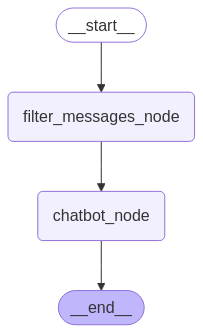

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import RemoveMessage
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Nodes
def filter_messages(state: State):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: State):    
    return {"messages": [llm.invoke(state["messages"])]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("filter_messages_node", filter_messages)
graph_builder.add_node("chatbot_node", chat_model_node)

# Connecto nodes
graph_builder.add_edge(START, "filter_messages_node")
graph_builder.add_edge("filter_messages_node", "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

As we see in the graph, first we filter the messages and then pass the result to the model.

We recreate a context that we will pass to the model, but now with more messages

In [32]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))
messages.append(AIMessage(f"I know about sharks too", name="Bot"))
messages.append(HumanMessage(f"What others should I learn about?", name="Lance"))
messages.append(AIMessage(f"I know about dolphins too", name="Bot"))
messages.append(HumanMessage(f"Tell me more about dolphins", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================
Name: Bot

I know about sharks too
================================ Human Message =================================
Name: Lance

What others should I learn about?
================================== Ai Message ==================================
Name: Bot

I know about dolphins too
================================ Human Message =================================
Name: Lance

Tell me more about dolphins


If we pass it to the graph, we will get the output

In [33]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

I know about dolphins too
================================ Human Message =================================
Name: Lance

Tell me more about dolphins
================================== Ai Message ==================================

Dolphins are highly intelligent marine mammals that are part of the family Delphinidae, which includes about 40 species. They are found in oceans worldwide, from tropical to temperate regions, and are known for their agility and playful behavior. Here are some interesting facts about dolphins:

1. **Social Behavior**: Dolphins are highly social animals and often live in groups called pods, which can range from a few individuals to several hundred. Social interactions are complex and include cooperative behaviors, such as hunting and defending against predators.

2. **Communication**: Dolphins communicate using a variety of sounds, including clicks, whistles, and body la

As can be seen, the filtering function has removed all messages except the last two, and those two messages have been passed as context to the LLM.

##### Trimming messages

Another solution is to trim each message from the list of messages that have too many tokens, a token limit is set and the message that exceeds this limit is removed.

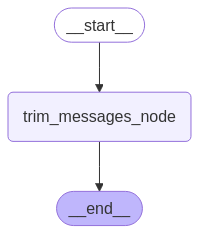

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import trim_messages
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Nodes
def trim_messages_node(state: State):
    # Trim the messages based on the specified parameters
    trimmed_messages = trim_messages(
        state["messages"],
        max_tokens=100,       # Maximum tokens allowed in the trimmed list
        strategy="last",     # Keep the latest messages
        token_counter=llm,   # Use the LLM's tokenizer to count tokens
        allow_partial=True,  # Allow cutting messages mid-way if needed
    )

    # Print the trimmed messages to see the effect of trim_messages
    print("--- trimmed messages (input to LLM) ---")
    for m in trimmed_messages:
        m.pretty_print()
    print("------------------------------------------------")

    # Invoke the LLM with the trimmed messages
    response = llm.invoke(trimmed_messages)

    # Return the LLM's response in the correct state format
    return {"messages": [response]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("trim_messages_node", trim_messages_node)

# Connecto nodes
graph_builder.add_edge(START, "trim_messages_node")
graph_builder.add_edge("trim_messages_node", END)

# Compile the graph
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

As we see in the graph, we first filter the messages and then pass the result to the model.

We recreate a context that we will pass to the model, but now with more messages

In [2]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))
messages.append(AIMessage(f"""I know about sharks too. They are very dangerous, but they are also very beautiful.
Sometimes have been seen in the wild, but they are not very common. In the wild, they are very dangerous, but they are also very beautiful.
They live in the sea and in the ocean. They can travel long distances and can be found in many parts of the world.
Often they live in groups of 20 or more, but they are not very common.
They should eat a lot of food. Normally they eat a lot of fish.
The white shark is the largest of the sharks and is the most dangerous.
The great white shark is the most famous of the sharks and is the most dangerous.
The tiger shark is the most aggressive of the sharks and is the most dangerous.
The hammerhead shark is the most beautiful of the sharks and is the most dangerous.
The mako shark is the fastest of the sharks and is the most dangerous.
The bull shark is the most common of the sharks and is the most dangerous.
""", name="Bot"))
messages.append(HumanMessage(f"What others should I learn about?", name="Lance"))
messages.append(AIMessage(f"I know about dolphins too", name="Bot"))
messages.append(HumanMessage(f"Tell me more about dolphins", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================
Name: Bot

I know about sharks too. They are very dangerous, but they are also very beautiful.
Sometimes have been seen in the wild, but they are not very common. In the wild, they are very dangerous, but they are also very beautiful.
They live in the sea and in the ocean. They can travel long distances and can be found in many parts of the world.
Often they live in groups of 20 or more, but they are not very common.
They should eat a lot of food. Normally they eat a lot of fish.
The white shark is the largest of the sharks and is the most dangerous.
The great white shark is the most famous of the sharks and is th

If we pass it to the graph, we will get the output

In [4]:
output = graph.invoke({'messages': messages})

--- trimmed messages (input to LLM) ---
================================== Ai Message ==================================
Name: Bot

The tiger shark is the most aggressive of the sharks and is the most dangerous.
The hammerhead shark is the most beautiful of the sharks and is the most dangerous.
The mako shark is the fastest of the sharks and is the most dangerous.
The bull shark is the most common of the sharks and is the most dangerous.
================================ Human Message =================================
Name: Lance

What others should I learn about?
================================== Ai Message ==================================
Name: Bot

I know about dolphins too
================================ Human Message =================================
Name: Lance

Tell me more about dolphins
------------------------------------------------


As can be seen, the context passed to the LLM has been truncated. The message, which was very long and had many tokens, has been cut off. Let's see the output of the LLM.

In [5]:
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================
Name: Bot

I know about sharks too. They are very dangerous, but they are also very beautiful.
Sometimes have been seen in the wild, but they are not very common. In the wild, they are very dangerous, but they are also very beautiful.
They live in the sea and in the ocean. They can travel long distances and can be found in many parts of the world.
Often they live in groups of 20 or more, but they are not very common.
They should eat a lot of food. Normally they eat a lot of fish.
The white shark is the largest of the sharks and is the most dangerous.
The great white shark is the most famous of the sharks and is th

With a truncated context, the LLM continues to answer

##### Modification of context and message trimming

Let's combine the two previous techniques, we will modify the context and trim the messages.

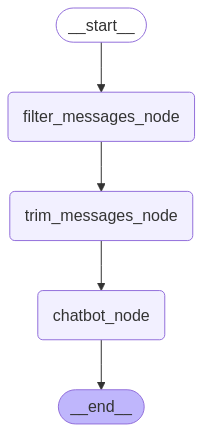

In [7]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import RemoveMessage, trim_messages
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Nodes
def filter_messages(state: State):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def trim_messages_node(state: State):
    # print the messages
    print("--- messages (input to trim_messages) ---")
    for m in state["messages"]:
        m.pretty_print()
    print("------------------------------------------------")

    # Trim the messages based on the specified parameters
    trimmed_messages = trim_messages(
        state["messages"],
        max_tokens=100,       # Maximum tokens allowed in the trimmed list
        strategy="last",     # Keep the latest messages
        token_counter=llm,   # Use the LLM's tokenizer to count tokens
        allow_partial=True,  # Allow cutting messages mid-way if needed
    )

    # Print the trimmed messages to see the effect of trim_messages
    print("--- trimmed messages (input to LLM) ---")
    for m in trimmed_messages:
        m.pretty_print()
    print("------------------------------------------------")

    # Invoke the LLM with the trimmed messages
    response = llm.invoke(trimmed_messages)

    # Return the LLM's response in the correct state format
    return {"messages": [response]}

def chat_model_node(state: State):    
    return {"messages": [llm.invoke(state["messages"])]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("filter_messages_node", filter_messages)
graph_builder.add_node("chatbot_node", chat_model_node)
graph_builder.add_node("trim_messages_node", trim_messages_node)

# Connecto nodes
graph_builder.add_edge(START, "filter_messages_node")
graph_builder.add_edge("filter_messages_node", "trim_messages_node")
graph_builder.add_edge("trim_messages_node", "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

Now we filter to keep the last two messages, then trim the context so that it doesn't use too many tokens, and finally pass the result to the model.

We create a context to pass it to the graph

In [8]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))
messages.append(AIMessage(f"I know about dolphins too", name="Bot"))
messages.append(HumanMessage(f"What others should I learn about?", name="Lance"))
messages.append(AIMessage(f"""I know about sharks too. They are very dangerous, but they are also very beautiful.
Sometimes have been seen in the wild, but they are not very common. In the wild, they are very dangerous, but they are also very beautiful.
They live in the sea and in the ocean. They can travel long distances and can be found in many parts of the world.
Often they live in groups of 20 or more, but they are not very common.
They should eat a lot of food. Normally they eat a lot of fish.
The white shark is the largest of the sharks and is the most dangerous.
The great white shark is the most famous of the sharks and is the most dangerous.
The tiger shark is the most aggressive of the sharks and is the most dangerous.
The hammerhead shark is the most beautiful of the sharks and is the most dangerous.
The mako shark is the fastest of the sharks and is the most dangerous.
The bull shark is the most common of the sharks and is the most dangerous.
""", name="Bot"))
messages.append(HumanMessage(f"What others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================
Name: Bot

I know about dolphins too
================================ Human Message =================================
Name: Lance

What others should I learn about?
================================== Ai Message ==================================
Name: Bot

I know about sharks too. They are very dangerous, but they are also very beautiful.
Sometimes have been seen in the wild, but they are not very common. In the wild, they are very dangerous, but they are also very beautiful.
They live in the sea and in the ocean. They can travel long distances and can be found in many parts of the world.
Often they live in groups

We pass it to the graph and get the output

In [9]:
output = graph.invoke({'messages': messages})

--- messages (input to trim_messages) ---
================================== Ai Message ==================================
Name: Bot

I know about sharks too. They are very dangerous, but they are also very beautiful.
Sometimes have been seen in the wild, but they are not very common. In the wild, they are very dangerous, but they are also very beautiful.
They live in the sea and in the ocean. They can travel long distances and can be found in many parts of the world.
Often they live in groups of 20 or more, but they are not very common.
They should eat a lot of food. Normally they eat a lot of fish.
The white shark is the largest of the sharks and is the most dangerous.
The great white shark is the most famous of the sharks and is the most dangerous.
The tiger shark is the most aggressive of the sharks and is the most dangerous.
The hammerhead shark is the most beautiful of the sharks and is the most dangerous.
The mako shark is the fastest of the sharks and is the most dangerous.
The

As we can see, we are only left with the last message, this is because the filtering function returned the last two messages, but the trimming function removed the second-to-last message for having more than 100 tokens.

Let's see what we have at the output of the model

In [10]:
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

I know about sharks too. They are very dangerous, but they are also very beautiful.
Sometimes have been seen in the wild, but they are not very common. In the wild, they are very dangerous, but they are also very beautiful.
They live in the sea and in the ocean. They can travel long distances and can be found in many parts of the world.
Often they live in groups of 20 or more, but they are not very common.
They should eat a lot of food. Normally they eat a lot of fish.
The white shark is the largest of the sharks and is the most dangerous.
The great white shark is the most famous of the sharks and is the most dangerous.
The tiger shark is the most aggressive of the sharks and is the most dangerous.
The hammerhead shark is the most beautiful of the sharks and is the most dangerous.
The mako shark is the fastest of the sharks and is the most dangerous.
The bull shark is the most common of the shar

We have filtered the state so much that the LLM does not have enough context. Later, we will see a way to solve this by adding a summary of the conversation to the state.

#### Streaming Modes

##### Synchronous streaming

In this case, we will receive the complete result of the LLM once it has finished generating the text.

To explain synchronous streaming modes, let's first create a basic graph.

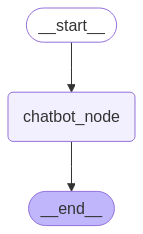

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import HumanMessage
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Nodes
def chat_model_node(state: State):
    # Return the LLM's response in the correct state format
    return {"messages": [llm.invoke(state["messages"])]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot_node", chat_model_node)

# Connecto nodes
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

Now we have two ways to obtain the result of the LLM, one is through the `updates` mode and the other through the `values` mode.

![updates vs values](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

While `updates` gives us each new result, `values` gives us the entire history of results.

###### Updates

In [2]:
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Máximo")]}, stream_mode="updates"):
    print(chunk['chatbot_node']['messages'][-1].content)

Hello Máximo! It's nice to meet you. How can I assist you today? Feel free to ask me any questions or let me know if you need help with anything specific.


###### Values

In [3]:
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Máximo")]}, stream_mode="values"):
    print(chunk['messages'][-1].content)

hi! I'm Máximo
Hello Máximo! It's nice to meet you. How can I assist you today? Feel free to ask me any questions or let me know if you need help with anything specific.


##### Asynchronous streaming

Now we are going to receive the result of the LLM token by token. For this, we have to add `streaming=True` when creating the HuggingFace LLM and we have to change the chatbot node function to be asynchronous.

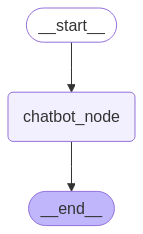

In [13]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import HumanMessage
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
    streaming=True,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Nodes
async def chat_model_node(state: State):
    async for token in llm.astream_log(state["messages"]):
        yield {"messages": [token]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot_node", chat_model_node)

# Connecto nodes
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

As can be seen, the function has been made asynchronous and turned into a generator since the `yield` returns a value and pauses the execution of the function until it is called again.

We are going to run the graph asynchronously and see the types of events that are generated.

In [7]:
try:
    async for event in graph.astream_events({"messages": [HumanMessage(content="hi! I'm Máximo")]}, version="v2"):
        print(f"event: {event}")
except Exception as e:
    print(f"Error: {e}")

event: {'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content="hi! I'm Máximo", additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'c9c40a00-157a-4229-a0d1-fda00e7bfd34', 'metadata': {}, 'parent_ids': []}
event: {'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content="hi! I'm Máximo", additional_kwargs={}, response_metadata={}, id='6469501c-07b0-42e4-a3e6-f133ace1860c')]}}, 'name': 'chatbot_node', 'tags': ['graph:step:1'], 'run_id': '638828c0-4add-4141-b6b6-484446100237', 'metadata': {'langgraph_step': 1, 'langgraph_node': 'chatbot_node', 'langgraph_triggers': ('branch:to:chatbot_node',), 'langgraph_path': ('__pregel_pull', 'chatbot_node'), 'langgraph_checkpoint_ns': 'chatbot_node:b7599990-0c1a-4133-fb2c-f32105784fbd'}, 'parent_ids': ['c9c40a00-157a-4229-a0d1-fda00e7bfd34']}
event: {'event': 'on_chain_start', 'data': {}, 'name': 'chatbot_node', 'tags': ['seq:step:1'], 'run_id': '15247b1a-1cd6-486

/Users/macm1/miniforge3/envs/langgraph/lib/python3.13/site-packages/huggingface_hub/inference/_generated/_async_client.py:2308: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(


event: {'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content=' or', additional_kwargs={}, response_metadata={})}, 'run_id': '74dfdbb9-4c2d-4a08-ad7d-795b5953cae3', 'name': 'ChatHuggingFace', 'tags': [], 'metadata': {'langgraph_step': 1, 'langgraph_node': 'chatbot_node', 'langgraph_triggers': ('branch:to:chatbot_node',), 'langgraph_path': ('__pregel_pull', 'chatbot_node'), 'langgraph_checkpoint_ns': 'chatbot_node:b7599990-0c1a-4133-fb2c-f32105784fbd', 'checkpoint_ns': 'chatbot_node:b7599990-0c1a-4133-fb2c-f32105784fbd', 'ls_provider': 'huggingface', 'ls_model_type': 'chat'}, 'parent_ids': ['c9c40a00-157a-4229-a0d1-fda00e7bfd34', '638828c0-4add-4141-b6b6-484446100237', '15247b1a-1cd6-4863-9402-66499f921244']}
event: {'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content=' let', additional_kwargs={}, response_metadata={})}, 'run_id': '74dfdbb9-4c2d-4a08-ad7d-795b5953cae3', 'name': 'ChatHuggingFace', 'tags': [], 'metadata': {'langgraph_step': 1, 'la

As can be seen, the tokens arrive with the event `on_chat_model_stream`, so we are going to capture it and print it.

In [14]:
try:
    async for event in graph.astream_events({"messages": [HumanMessage(content="hi! I'm Máximo")]}, version="v2"):
        if event["event"] == "on_chat_model_stream":
            print(event["data"]["chunk"].content, end=" | ", flush=True)
except Exception as e:
    pass

/Users/macm1/miniforge3/envs/langgraph/lib/python3.13/site-packages/huggingface_hub/inference/_generated/_async_client.py:2308: FutureWarning: `stop_sequences` is a deprecated argument for `text_generation` task and will be removed in version '0.28.0'. Use `stop` instead.
  warnings.warn(


Hello |  Má | ximo | ! |  It | 's |  nice |  to |  meet |  you | . |  How |  can |  I |  assist |  you |  today | ? |  Feel |  free |  to |  ask |  me |  any |  questions |  or |  let |  me |  know |  if |  you |  need |  help |  with |  anything |  specific | . | <|im_end|> | 

#### Subgraphs

We have previously seen how to fork a graph so that nodes run in parallel, but let's consider the case where what we want to run in parallel are subgraphs. So, let's see how to do it.

Let's see how to create a log management graph that will have a subgraph for log summary and another subgraph for error analysis in the logs.

![graph with subgraphs](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb1abf89f2d847ee6f1ff_sub-graph1.png)

So what we are going to do is first define each of the subgraphs separately and then add them to the main graph.

##### Subgraph for log error analysis

We import the necessary libraries

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

We create a class with the structure of the logs

In [11]:
# The structure of the logs
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

We now create two classes, one with the structure of the log errors and another with the analysis that will be reported to the output.

In [12]:
# Failure Analysis Sub-graph
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

We now create the functions for the nodes, one will obtain the failures in the logs, for this it will search for logs that have any value in the `grade` field. Another will generate a summary of the failures. Additionally, we will add `print`s to be able to see what is happening internally.

In [13]:
def get_failures(state):
    """ Get logs that contain a failure """
    cleaned_logs = state["cleaned_logs"]
    print(f"\t debug get_failures: cleaned_logs: {cleaned_logs}")

    failures = [log for log in cleaned_logs if "grade" in log]
    print(f"\t debug get_failures: failures: {failures}")

    return {"failures": failures}

def generate_summary(state):
    """ Generate summary of failures """
    failures = state["failures"]
    print(f"\t debug generate_summary: failures: {failures}")

    fa_summary = "Poor quality retrieval of documentation."
    print(f"\t debug generate_summary: fa_summary: {fa_summary}")

    processed_logs = [f"failure-analysis-on-log-{failure['id']}" for failure in failures]
    print(f"\t debug generate_summary: processed_logs: {processed_logs}")
    
    return {"fa_summary": fa_summary, "processed_logs": processed_logs}

Finally, we create the graph, add the nodes and the `edges` and compile it.

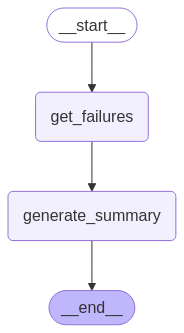

In [14]:
fa_builder = StateGraph(FailureAnalysisState,output=FailureAnalysisOutputState)

fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)

fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

Let's create a test log

In [15]:
failure_log = {
    "id": "1", 
    "question": "What is the meaning of life?", 
    "docs": None, 
    "answer": "42", 
    "grade": 1, 
    "grader": "AI", 
    "feedback": "Good job!"
}

We run the graph with the test log. Since the function `get_failures` takes the key `cleaned_logs` from the state, we have to pass the log to the graph under that same key.

In [16]:
graph.invoke({"cleaned_logs": [failure_log]})

	 debug get_failures: cleaned_logs: [{'id': '1', 'question': 'What is the meaning of life?', 'docs': None, 'answer': '42', 'grade': 1, 'grader': 'AI', 'feedback': 'Good job!'}]
	 debug get_failures: failures: [{'id': '1', 'question': 'What is the meaning of life?', 'docs': None, 'answer': '42', 'grade': 1, 'grader': 'AI', 'feedback': 'Good job!'}]
	 debug generate_summary: failures: [{'id': '1', 'question': 'What is the meaning of life?', 'docs': None, 'answer': '42', 'grade': 1, 'grader': 'AI', 'feedback': 'Good job!'}]
	 debug generate_summary: fa_summary: Poor quality retrieval of documentation.
	 debug generate_summary: processed_logs: ['failure-analysis-on-log-1']


{'fa_summary': 'Poor quality retrieval of documentation.',
 'processed_logs': ['failure-analysis-on-log-1']}

It can be seen that it has found the test log, as it has a value of `1` in the `grade` field and then generated a summary of the failures.

Let's define the entire subgraph together again so it looks clearer and also to remove the `print`s we added for debugging.

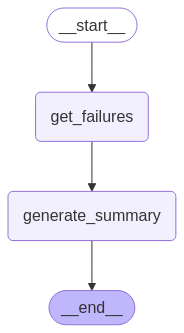

In [17]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

# The structure of the logs
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

# Failure clases
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

# Functions
def get_failures(state):
    """ Get logs that contain a failure """
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

def generate_summary(state):
    """ Generate summary of failures """
    failures = state["failures"]
    fa_summary = "Poor quality retrieval of documentation."
    processed_logs = [f"failure-analysis-on-log-{failure['id']}" for failure in failures]
    return {"fa_summary": fa_summary, "processed_logs": processed_logs}

# Build the graph
fa_builder = StateGraph(FailureAnalysisState,output=FailureAnalysisOutputState)

fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)

fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

If we run it again now, we get the same result, but without the `print`s.

In [18]:
graph.invoke({"cleaned_logs": [failure_log]})

{'fa_summary': 'Poor quality retrieval of documentation.',
 'processed_logs': ['failure-analysis-on-log-1']}

##### Subgraph of log summary

Now we create the log summary subgraph. In this case, there's no need to recreate the class with the log structure, so we create the classes with the structure for the log summaries and the output structure.

In [19]:
# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

Now we define the functions of the nodes, one will generate the summary of the logs and another will "send the summary to Slack".

In [23]:
def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    print(f"\t debug generate_summary: cleaned_logs: {cleaned_logs}")

    summary = "Questions focused on ..."
    print(f"\t debug generate_summary: summary: {summary}")

    processed_logs = [f"summary-on-log-{log['id']}" for log in cleaned_logs]
    print(f"\t debug generate_summary: processed_logs: {processed_logs}")

    return {"qs_summary": summary, "processed_logs": processed_logs}

def send_to_slack(state):
    qs_summary = state["qs_summary"]
    print(f"\t debug send_to_slack: qs_summary: {qs_summary}")

    report = "foo bar baz"
    print(f"\t debug send_to_slack: report: {report}")

    return {"report": report}

Finally, we create the graph, add the nodes and the `edges` and compile it.

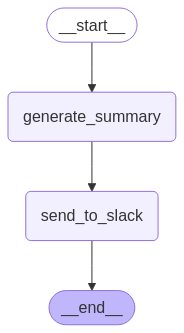

In [24]:
# Build the graph
qs_builder = StateGraph(QuestionSummarizationState,output=QuestionSummarizationOutputState)

qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)

qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

We try again with the log we created earlier.

In [25]:
graph.invoke({"cleaned_logs": [failure_log]})

	 debug generate_summary: cleaned_logs: [{'id': '1', 'question': 'What is the meaning of life?', 'docs': None, 'answer': '42', 'grade': 1, 'grader': 'AI', 'feedback': 'Good job!'}]
	 debug generate_summary: summary: Questions focused on ...
	 debug generate_summary: processed_logs: ['summary-on-log-1']
	 debug send_to_slack: qs_summary: Questions focused on ...
	 debug send_to_slack: report: foo bar baz


{'report': 'foo bar baz', 'processed_logs': ['summary-on-log-1']}

We rewrite the subgraph, all together for greater clarity and without the `print`s.

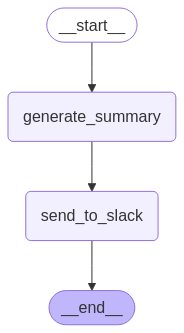

In [27]:
# Summarization clases
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

# Functions
def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    summary = "Questions focused on ..."
    processed_logs = [f"summary-on-log-{log['id']}" for log in cleaned_logs]
    return {"qs_summary": summary, "processed_logs": processed_logs}

def send_to_slack(state):
    qs_summary = state["qs_summary"]
    report = "foo bar baz"
    return {"report": report}

# Build the graph
qs_builder = StateGraph(QuestionSummarizationState,output=QuestionSummarizationOutputState)

qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)

qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

We run the graph again with the test log.

In [28]:
graph.invoke({"cleaned_logs": [failure_log]})

{'report': 'foo bar baz', 'processed_logs': ['summary-on-log-1']}

##### Main graph

Now that we have the two subgraphs, we can create the main graph that will use them. To do this, we create the `EntryGraphState` class, which will hold the state of the two subgraphs.

In [29]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

We create a log cleaning function, which will be a node that runs before the two subgraphs and provides them with clean logs through the key `cleaned_logs`, which is what the two subgraphs take from the state.

In [32]:
def clean_logs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    # Data cleaning raw_logs -> docs 
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

Now we create the main graph

In [33]:
# Build the graph
entry_builder = StateGraph(EntryGraphState)

We add the nodes. To add a subgraph as a node, what we do is add its compilation.

In [34]:
# Add nodes
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

From here on out, we add the `edges` and compile it.

In [36]:
# Add edges
entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

# Compile the graph
graph = entry_builder.compile()

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


Finally, we display the graph. We add `xray=1` to show the internal state of the graph.

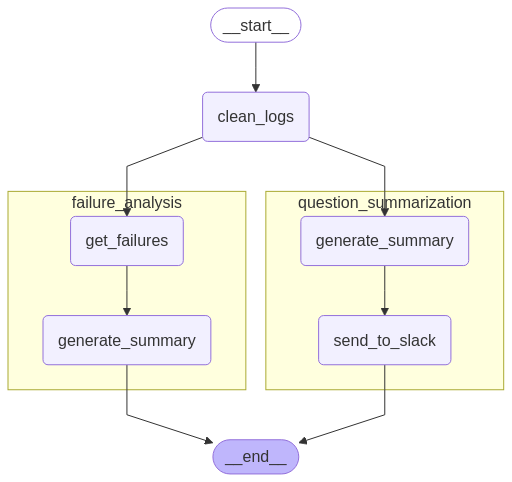

In [37]:
# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

If we hadn't added `xray=1`, the graph would look like this

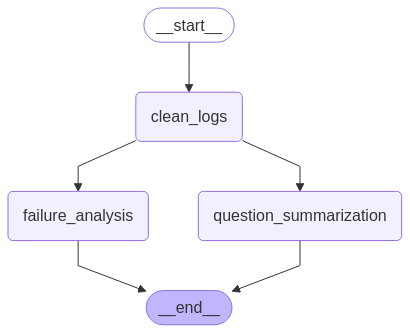

In [38]:
display(Image(graph.get_graph().draw_mermaid_png()))


Now we create two test logs, in one there will be an error (a value in `grade`) and in the other there won't be.

In [39]:
# Dummy logs
question_answer = Log(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

raw_logs = [question_answer,question_answer_feedback]

We pass it to the main graph

In [40]:
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, 

Just like before, we write the entire graph to see it more clearly

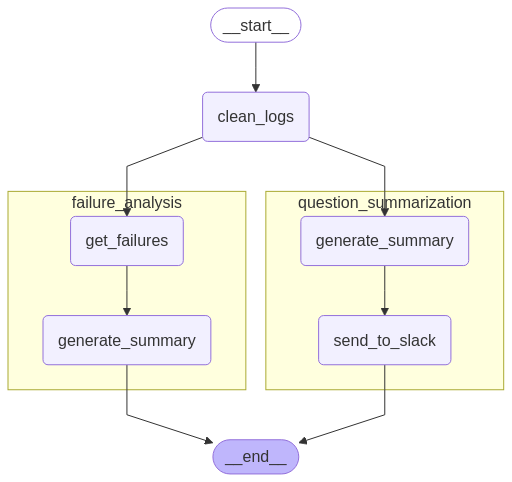

In [41]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

# Functions
def clean_logs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    # Data cleaning raw_logs -> docs 
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

# Build the graph
entry_builder = StateGraph(EntryGraphState)

# Add nodes
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

# Add edges
entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

# Compile the graph
graph = entry_builder.compile()

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

We pass the test logs to the main graph

In [42]:
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, 

#### Dynamic branches

So far we have created static nodes and `edges`, but there are times when we don't know if we will need a branch until the graph is executed. For this, we can use the `SEND` method of langgraph, which allows us to create branches dynamically.

To see it, we are going to create a graph that generates jokes about some topics, but since we don't know in advance how many topics we want to generate jokes for, using the `SEND` method, we will dynamically create branches so that if there are still topics left to generate, a new branch will be created.

> Note: We will be doing this section using Sonnet 3.7, as the HuggingFace integration does not have the `with_structured_output` functionality that provides a structured output with a defined structure.

First we import the necessary libraries.

In [1]:
import operator
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START

from langchain_anthropic import ChatAnthropic

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

from IPython.display import Image

We create the classes with the structure of the state.

In [2]:
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

class JokeState(TypedDict):
    subject: str

We create the LLM

In [3]:
# Create the LLM model
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)

We create the function that will generate the themes.

We are going to use `with_structured_output` so that the LLM generates an output with a structure defined by us, and we will define that structure using the `Subjects` class, which is a `BaseModel` class from `Pydantic`.

In [4]:
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""

def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = llm.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

Now we define the function that will generate the jokes.

In [5]:
class Joke(BaseModel):
    joke: str
    
joke_prompt = """Generate a joke about {subject}"""

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = llm.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

And finally, the function that will select the best joke.

In [6]:
class BestJoke(BaseModel):
    id: int

best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = llm.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

Now we are going to create a function that decides whether to create a new branch with `SEND` or not, and to decide this it will check if there are any topics left to generate.

In [7]:
from langgraph.constants import Send

def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

We build the graph, add the nodes and the `edges`.

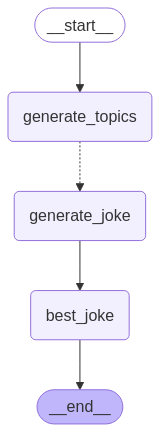

In [8]:
# Build the graph
graph = StateGraph(OverallState)

# Add nodes
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)

# Add edges
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()

# Display the graph
Image(app.get_graph().draw_mermaid_png())

As can be seen, the `edge` between `generate_topics` and `generate_joke` is represented with a dashed line, indicating that it is a dynamic branch.

We now create a dictionary with the key `topic`, which is needed by the `generate_topics` node to generate the topics, and pass it to the graph.

In [9]:
# Call the graph: here we call it to generate a list of jokes
for state in app.stream({"topic": "animals"}):
    print(state)

{'generate_topics': {'subjects': ['Marine Animals', 'Endangered Species', 'Animal Behavior']}}
{'generate_joke': {'jokes': ["Why don't cats play poker in the wild? Too many cheetahs!"]}}
{'generate_joke': {'jokes': ["Why don't sharks eat clownfish? Because they taste funny!"]}}
{'generate_joke': {'jokes': ["Why don't endangered species tell jokes? Because they're afraid of dying out from laughter!"]}}
{'best_joke': {'best_selected_joke': "Why don't cats play poker in the wild? Too many cheetahs!"}}


We recreate the graph with all the code together for greater clarity.

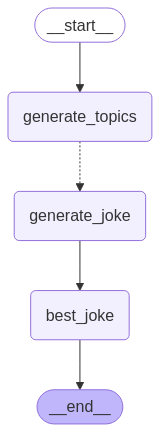

In [1]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

from langgraph.graph import END, StateGraph, START
from langgraph.constants import Send

from langchain_anthropic import ChatAnthropic

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

from IPython.display import Image

# Prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

# Create the LLM model
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)

class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = llm.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = llm.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = llm.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

# Build the graph
graph = StateGraph(OverallState)

# Add nodes
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)

# Add edges
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()

# Display the graph
Image(app.get_graph().draw_mermaid_png())

We run it again, but this time, instead of `animals`, we will use `cars`

In [2]:
for state in app.stream({"topic": "cars"}):
    print(state)

{'generate_topics': {'subjects': ['Car Maintenance and Repair', 'Electric and Hybrid Vehicles', 'Automotive Design and Engineering']}}
{'generate_joke': {'jokes': ["Why don't electric cars tell jokes? They're afraid of running out of charge before they get to the punchline!"]}}
{'generate_joke': {'jokes': ["Why don't automotive engineers play hide and seek? Because good luck hiding when you're always making a big noise about torque!"]}}
{'generate_joke': {'jokes': ["Why don't cars ever tell their own jokes? Because they always exhaust themselves during the delivery! Plus, their timing belts are always a little off."]}}
{'best_joke': {'best_selected_joke': "Why don't electric cars tell jokes? They're afraid of running out of charge before they get to the punchline!"}}


## Improve the chatbot with tools

To handle some queries, our chatbot cannot respond `from its knowledge`, so we are going to integrate a web search tool. Our bot can use this tool to find relevant information and provide better answers.

### Requirements

Before we start, we need to install the [Tavily](https://python.langchain.com/docs/integrations/tools/tavily_search/) search engine, which is a web search tool that allows us to look up information on the web.

```bash
pip install -U tavily-python langchain_community
```

After that, we need to create an [API KEY](https://app.tavily.com/home), write it in our `.env` file, and load it into a variable.

In [1]:
import dotenv
import os

dotenv.load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

### Chatbot with tools

First we create the state and the LLM

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login

import json
import os
from IPython.display import Image, display

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

class State(TypedDict):
    messages: Annotated[list, add_messages]

# Create the LLM
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

Now, we define the web search tool using [TavilySearchResults](https://python.langchain.com/api_reference/community/tools/langchain_community.tools.tavily_search.tool.TavilySearchResults.html)

In [2]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)

We test the tool, we are going to do an internet search.

In [3]:
tool.invoke("What was the result of Real Madrid's at last match in the Champions League?")

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


[{'title': 'HIGHLIGHTS | Real Madrid 3-2 Leganés | LaLiga 2024/25 - YouTube',
  'url': 'https://www.youtube.com/watch?v=Np-Kwz4RDpY',
  'content': "20:14 · Go to channel · RONALDO'S LAST MATCH WITH REAL MADRID: THE MOST THRILLING FINAL EVER! ... Champions League 1/4 Final | PES. Football",
  'score': 0.65835214},
 {'title': 'Real Madrid | History | UEFA Champions League',
  'url': 'https://www.uefa.com/uefachampionsleague/history/clubs/50051--real-madrid/',
  'content': '1955/56 P W D L Final 7 5 0 2\nUEFA Champions League [...] 2010/11 P W D L Semi-finals 12 8 3 1\n2009/10 P W D L Round of 16 8 4 2 2\n2000s\n2008/09 P W D L Round of 16 8 4 0 4\n2007/08 P W D L Round of 16 8 3 2 3\n2006/07 P W D L Round of 16 8 4 2 2\n2005/06 P W D L Round of 16 8 3 2 3\n2004/05 P W D L Round of 16 10 6 2 2\n2003/04 P W D L Quarter-finals 10 6 3 1\n2002/03 P W D L Semi-finals 16 7 5 4\n2001/02 P W D L Final 17 12 3 2\n2000/01 P W D L Semi-finals 16 9 2 5\n1990s\n1999/00 P W D L Final 17 10 3 4\n1998/99

The results are summaries of pages that our chatbot can use to answer questions.

We create a list of tools because our graph needs to define the tools through a list.

In [3]:
tools_list = [tool]

Now that we have the list of `tools` we create a `llm_with_tools`

In [4]:
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

We define the function that will go in the chat bot node

In [5]:
# Define the chatbot function
def chatbot_function(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

We need to create a function to execute the `tools_list` if they are called. We add the `tools_list` to a new node.

Later we will do this with the [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) method of `LangGraph`, but first we will build it ourselves to understand how it works.

We are going to implement the `BasicToolNode` class, which checks the most recent message in the state and calls the `tools_list` if the message contains `tool_calls`.

It is based on the support for `tool_calling` in `LLMs`, which is available in `Anthropic`, `HuggingFace`, `Google Gemini`, `OpenAI`, and several other `LLM` providers.

In [6]:
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        """
        Initialize the tools

        Args:
            tools (list): The tools to use

        Returns:
            None
        """
        # Initialize the tools
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        """
        Call the node

        Args:
            inputs (dict): The inputs to the node

        Returns:
            dict: The outputs of the node
        """
        # Get the last message
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        
        # Execute the tools
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

basic_tool_node = BasicToolNode(tools=tools_list)

We have used [ToolMessage](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.tool.ToolMessage.html) that passes the result of running a `tool` back to the `LLM`.

`ToolMessage` contains the result of an invocation of a `tool`.

That is, as soon as we have the result of using a `Tool`, we pass it to the LLM for processing.

With the `basic_tool_node` object (which is an object of the class `BasicToolNode` that we have created), we can now make the LLM execute `tool`s

Now, just like we did when building a basic chatbot, we are going to create the graph and add nodes to it.

In [8]:
# Create graph
graph_builder = StateGraph(State)

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)
graph_builder.add_node("tools_node", basic_tool_node)

When the LLM receives a message, since it knows the `tools` available to it, it will decide whether to respond or use a `tool`. So, we are going to create a routing function that will execute a `tool` if the LLM decides to use it, or otherwise terminate the graph execution.

In [7]:
def route_tools_function(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    # Get last message
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    # Router in function of last message
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools_node"
    return END

We add the `edges`.

We need to add a special `edge` using `add_conditional_edges`, which will create a conditional node. Connect the `chatbot_node` with the routing function we created earlier, `route_tools_function`. With this node, if we get the string `tools_node` as output from `route_tools_function`, it will route the graph to the `tools_node`, but if we receive `END`, it will route the graph to the `END` node and terminate the execution of the graph.

Later, we will replace this with the built-in method `tools_condition`, but for now we implement it ourselves to see how it works.

Finally, another `edge` is added that connects `tools_node` with `chatbot_node`, so that when a `tool` finishes executing, the graph returns to the `LLM` node.

In [9]:
# Add edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_conditional_edges(
    "chatbot_node",
    route_tools_function,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools_node": "tools_node", END: END},
)
graph_builder.add_edge("tools_node", "chatbot_node")

We compile the node and represent it

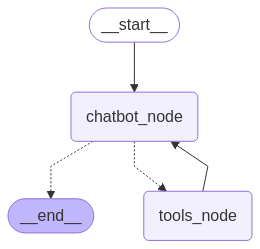

In [10]:
graph = graph_builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Now we can ask the bot questions outside of its training data

In [15]:
# Colors for the terminal
COLOR_GREEN = "\033[32m"
COLOR_YELLOW = "\033[33m"
COLOR_RESET = "\033[0m"


def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}{value['messages'][-1].content}")

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: How did Real Madrid fare this weekend against Leganes in La Liga?
Assistant: 
User: How did Real Madrid fare this weekend against Leganes in La Liga?
Assistant: [{"title": "Real Madrid 3-2 Leganes: Goals and highlights - LaLiga 24/25 | Marca", "url": "https://www.marca.com/en/soccer/laliga/r-madrid-leganes/2025/03/29/01_0101_20250329_186_957-live.html", "content": "While their form has varied throughout the campaign there is no denying Real Madrid are a force at home in LaLiga this season, as they head into Saturday's match having picked up 34 points from 13 matches.\n\nAs for Leganes they currently sit 18th in the table, though they are level with Alaves for 17th as both teams look to stay in the top flight. [...] The two teams have already played twice this season, with Real Madrid securing a 3-0 win in the reverse league fixture. They also met in the quarter-finals of the Copa del Rey, a game Real won 3-2.\n\nReal Madrid vs Leganes LIVE - Latest Updates\n\nMatch ends, Real Mad

As you can see, I first asked him how the Real Madrid did in their last La Liga match against Leganés.
As it is something current, he has decided to use the search tool, which has yielded the result.

However, when I asked him which players played, he didn't know what I was talking about, that's because the conversation context is not being maintained. So the next thing we are going to do is add a memory to the agent so it can keep track of the conversation context.

Let's write everything together so it's more readable

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login

from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_core.messages import ToolMessage

from IPython.display import Image, display
import json

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Tools
wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)
tools_list = [tool]
# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)
# Create the LLM with tools
llm_with_tools = llm.bind_tools(tools_list)

# BasicToolNode class
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        """
        Initialize the tools

        Args:
            tools (list): The tools to use

        Returns:
            None
        """
        # Initialize the tools
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        """
        Call the node

        Args:
            inputs (dict): The inputs to the node

        Returns:
            dict: The outputs of the node
        """
        # Get the last message
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        
        # Execute the tools
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

basic_tool_node = BasicToolNode(tools=tools_list)

# Functions
def chatbot_function(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Route function
def route_tools_function(state: State):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    # Get last message
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    # Router in function of last message
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools_node"
    return END

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("chatbot_node", chatbot_function)
graph_builder.add_node("tools_node", basic_tool_node)

# Add edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_conditional_edges(
    "chatbot_node",
    route_tools_function,
    {
        "tools_node": "tools_node",
        END: END
    },
)
graph_builder.add_edge("tools_node", "chatbot_node")

# Compile the graph
graph = graph_builder.compile()

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Error al visualizar el grafo: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`


We run the graph

In [2]:
# Colors for the terminal
COLOR_GREEN = "\033[32m"
COLOR_YELLOW = "\033[33m"
COLOR_RESET = "\033[0m"


def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}{value['messages'][-1].content}")

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print(f"{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
            print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  How did Real Madrid fare this weekend against Leganes in La Liga?
Assistant: 
User:  How did Real Madrid fare this weekend against Leganes in La Liga?
Assistant: [{"title": "Real Madrid 3-2 Leganes: Mbappe, Bellingham inspire comeback to ...", "url": "https://www.nbcsports.com/soccer/news/how-to-watch-real-madrid-vs-leganes-live-stream-link-tv-team-news-prediction", "content": "Real Madrid fought back to beat struggling Leganes 3-2 at the Santiago Bernabeu on Saturday as Kylian Mbappe scored twice and Jude", "score": 0.78749067}, {"title": "Real Madrid vs Leganes 3-2: LaLiga \u2013 as it happened - Al Jazeera", "url": "https://www.aljazeera.com/sports/liveblog/2025/3/29/live-real-madrid-vs-leganes-laliga", "content": "Defending champions Real Madrid beat 3-2 Leganes in Spain's LaLiga. The match at Santiago Bernabeu in Madrid, Spain saw Real trail 2-1 at half-", "score": 0.7485182}]
User:  How did Real Madrid fare this weekend against Leganes in La Liga?
Assistant: 
User:  How di

We see again that the problem is that it does not remember the context of the conversation.

## Add memory to the chatbot - short-term memory, memory within the thread

Our chatbot can now use tools to answer users' questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent and multi-turn conversations.

`LangGraph` solves this problem through persistent checkpoints or `checkpoints`. If we provide a `checkpointer` when compiling the graph and a `thread_id` when calling the graph, `LangGraph` automatically saves the state after each iteration in the conversation.

When we invoke the graph again using the same `thread_id`, the graph will load its saved state, allowing the chatbot to continue where it left off.

We will see later that this `checkpointing` is much more powerful than simple chat memory: it allows saving and resuming complex states at any time for error recovery, workflows with `human in the loop`, interactions over time, and more. But before we get to all of that, let's add checkpoints to enable multi-iteration conversations.

In [1]:
import os
import dotenv

dotenv.load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

To start, we create a `checkpointer` [MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver).

In [2]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

> **Notice**
>
> We are using an in-memory `checkpointer`, meaning it is stored in RAM and when the graph execution finishes, it is deleted. This works for our case, as it is an example to learn how to use `LangGraph`. In a production application, it is likely that this would need to be changed to use `SqliteSaver` or `PostgresSaver` and connect to our own database.

Below, we define the graph.

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

We define the `tool`

In [4]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)
tools_list = [tool]

Next, the `LLM` with the `bind_tools` and we add it to the graph

In [5]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)

Previously, we built our own `BasicToolNode` to learn how it works. Now, we will replace it with the LangGraph `ToolNode` and `tools_condition` methods, as these do some good things like parallel API execution. Apart from that, the rest is the same as before.

In [6]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

We add the `tools_condition` node to the graph

In [7]:
graph_builder.add_conditional_edges(
    "chatbot_node",
    tools_condition,
)

We add the `tools` node to the graph

In [8]:
graph_builder.add_edge("tools", "chatbot_node")

We add the `START` node to the graph

In [9]:
graph_builder.add_edge(START, "chatbot_node")

We compile the graph by adding the `checkpointer`

In [10]:
graph = graph_builder.compile(checkpointer=memory)

We represent it graphically

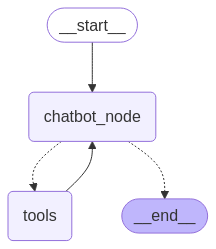

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

We create a configuration with a `thread_id` of a user

In [12]:
USER1_THREAD_ID = "1"
config_USER1 = {"configurable": {"thread_id": USER1_THREAD_ID}}

In [14]:
user_input = "Hi there! My name is Maximo."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER1,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Maximo.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (0)
 Call ID: 0
  Args:
    query:  does not reside in any location,}},
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Determining an individual's tax residency status - IRS", "url": "https://www.irs.gov/individuals/international-taxpayers/determining-an-individuals-tax-residency-status", "content": "If you are not a U.S. citizen, you are considered a nonresident of the United States for U.S. tax purposes unless you meet one of two tests.", "score": 0.1508904}, {"title": "Fix \"Location Is Not Available\", C:\\WINDOWS\\system32 ... - YouTube", "url": "https://www.youtube.com/watch?v=QFD-Ptp0SJw", "content": "Fix Error \"Location is not available\" C:\\WINDOWS\\system32\\config\\

In [15]:
user_input = "Do you remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER1,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Do you remember my name?
================================== Ai Message ==================================

Of course! You mentioned your name is Maximo.


As can be seen, we haven't passed a list with the messages; everything is being managed by the `checkpointer`.

If we now try with another user, that is, with another `thread_id`, we will see that the graph does not remember the previous conversation.

In [16]:
USER2_THREAD_ID = "2"
config_USER2 = {"configurable": {"thread_id": USER2_THREAD_ID}}

user_input = "Do you remember my name?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER2,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Do you remember my name?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (0)
 Call ID: 0
  Args:
    query: Do you Remember My Name
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Sam Fender - Remember My Name (Official Video) - YouTube", "url": "https://www.youtube.com/watch?v=uaQm48G6IjY", "content": "Sam Fender - Remember My Name (Official Video) \n SamFenderVEVO \n 10743 likes \n 862209 views \n 14 Feb 2025 \n Remember My Name is a love song dedicated to my late Grandparents - they were always so fiercely proud of our family so I wrote the song in honour of them, from the perspective of my Grandad who was looking after my Grandma when she was suffering from dementia. This video is a really special one for me and I want to say thank you to everyone inv

Now that our chatbot has search and memory tools, we are going to repeat the previous example, where I ask it about the result of Real Madrid's last match in the League and then which players played.

In [17]:
USER3_THREAD_ID = "3"
config_USER3 = {"configurable": {"thread_id": USER3_THREAD_ID}}

user_input = "How did Real Madrid fare this weekend against Leganes in La Liga?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER3,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

How did Real Madrid fare this weekend against Leganes in La Liga?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (0)
 Call ID: 0
  Args:
    query: Real Madrid vs Leganes La Liga this weekend
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Real Madrid 3-2 Leganes: Goals and highlights - LaLiga 24/25 | Marca", "url": "https://www.marca.com/en/soccer/laliga/r-madrid-leganes/2025/03/29/01_0101_20250329_186_957-live.html", "content": "While their form has varied throughout the campaign there is no denying Real Madrid are a force at home in LaLiga this season, as they head into Saturday's match having picked up 34 points from 13 matches.\n\nAs for Leganes they currently sit 18th in the table, though they are level with Alaves for 17th as both teams look to st

Now we ask for the players who played in the match.

In [18]:
user_input = "Which players played the match?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER3,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Which players played the match?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (0)
 Call ID: 0
  Args:
    query: Real Madrid vs Leganes match report players lineup
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Real Madrid vs. Leganes final score: La Liga result, updates, stats ...", "url": "https://www.sportingnews.com/us/soccer/news/real-madrid-leganes-score-result-updates-stats-la-liga/8ecf730cfcb9b6c5f6693a0d", "content": "Real Madrid came through a topsy-turvy game with Leganes to claim a 3-2 victory and put pressure back on Barcelona in La Liga's title race. Kylian Mbappe scored in each half either side of a Jude Bellingham goal — his first in the league since January 3 — to seal all three points for the champions after Leganes had come from behi

After much searching, he finally finds it. So now we have a chatbot with `tools` and memory.

So far, we have created some `checkpoints` in three different threads. But, what goes into each `checkpoint`? To inspect the state of a graph for a given configuration, we can use the method `get_state(config)`.

In [19]:
snapshot = graph.get_state(config_USER3)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='How did Real Madrid fare this weekend against Leganes in La Liga?', additional_kwargs={}, response_metadata={}, id='a33f5825-1ae4-4717-ad17-8e306f35b027'), AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': {'query': 'Real Madrid vs Leganes La Liga this weekend'}, 'name': 'tavily_search_results_json', 'description': None}, 'id': '0', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 296, 'total_tokens': 321}, 'model': '', 'finish_reason': 'stop'}, id='run-7905b5ae-5dee-4641-b012-396affde984c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Real Madrid vs Leganes La Liga this weekend'}, 'id': '0', 'type': 'tool_call'}]), ToolMessage(content='[{"title": "Real Madrid 3-2 Leganes: Goals and highlights - LaLiga 24/25 | Marca", "url": "https://www.marca.com/en/soccer/laliga/r-madrid-leganes/2025/03/29/01_0101_20250329_186_957-live

If we want to see the next node to be processed, we can use the `next` attribute.

In [20]:
snapshot.next

()

Since the graph has finished, `next` is empty. If you get a state from within a graph invocation, `next` indicates which node will run next.

The previous snapshot (`snapshot`) contains the current state values, the corresponding configuration, and the next node (`next`) to process. In our case, the graph has reached the `END` state, which is why `next` is empty.

We are going to rewrite all the code to make it more readable.

In [3]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login

from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display
import json

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Tools
wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)
tools_list = [tool]

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)
# Create the LLM with tools
llm_with_tools = llm.bind_tools(tools_list)

# Tool node
tool_node = ToolNode(tools=tools_list)

# Functions
def chatbot_function(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("chatbot_node", chatbot_function)
graph_builder.add_node("tools", tool_node)

# Add edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_conditional_edges( "chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")

# Compile the graph
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Error al visualizar el grafo: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`


In [4]:
USER1_THREAD_ID = "1"
config_USER1 = {"configurable": {"thread_id": USER1_THREAD_ID}}

user_input = "Hi there! My name is Maximo."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER1,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Maximo.
================================== Ai Message ==================================

Hello Maximo! It's nice to meet you. How can I assist you today? Feel free to ask me any questions or let me know if you need help with anything specific.


In [5]:
user_input = "Do you remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config_USER1,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Do you remember my name?
================================== Ai Message ==================================

Yes, I remember your name! You mentioned it's Maximo. It's nice to chat with you, Maximo. How can I assist you today?


**Congratulations!** Our chatbot can now maintain conversation state across all sessions thanks to the checkpoint system of `LangGraph`. This opens up possibilities for more natural and contextual interactions. The `LangGraph` controller even handles complex graph states.

### More

#### Chatbot with summary message

If we are going to manage the conversation context to avoid using too many tokens, one thing we can do to improve the conversation is to add a message with a summary of the conversation. This can be useful for the previous example, where we have filtered out so much state that the LLM does not have enough context.

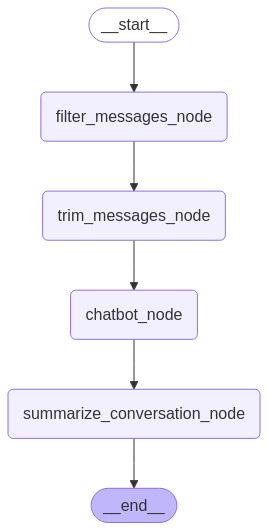

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import RemoveMessage, trim_messages, SystemMessage, HumanMessage, AIMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

memory_saver = MemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]
    summary: str

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Print functions
def print_message(m):
    if isinstance(m, HumanMessage):
        message_content = m.content
        message_lines = message_content.split("\n")
        for i, line in enumerate(message_lines):
            if i == 0:
                print(f"\t\t[HumanMessage]: {line}")
            else:
                print(f"\t\t{line}")
    elif isinstance(m, SystemMessage):
        message_content = m.content
        message_lines = message_content.split("\n")
        for i, line in enumerate(message_lines):
            if i == 0:
                print(f"\t\t[SystemMessage]: {line}")
            else:
                print(f"\t\t{line}")
    elif isinstance(m, AIMessage):
        message_content = m.content
        message_lines = message_content.split("\n")
        for i, line in enumerate(message_lines):
            if i == 0:
                print(f"\t\t[AIMessage]: {line}")
            else:
                print(f"\t\t{line}")
    elif isinstance(m, RemoveMessage):
        message_content = m.content
        message_lines = message_content.split("\n")
        for i, line in enumerate(message_lines):
            if i == 0:
                print(f"\t\t[RemoveMessage]: {line}")
            else:
                print(f"\t\t{line}")
    else:
        message_content = m.content
        message_lines = message_content.split("\n")
        for i, line in enumerate(message_lines):
            if i == 0:
                print(f"\t\t[{type(m)}]: {line}")
            else:
                print(f"\t\t{line}")

def print_state_summary(state: State):
    if state.get("summary"):
        summary_lines = state["summary"].split("\n")
        for i, line in enumerate(summary_lines):
            if i == 0:
                print(f"\t\tSummary of the conversation: {line}")
            else:
                print(f"\t\t{line}")
    else:
        print("\t\tNo summary of the conversation")

def print_summary(summary: str):
    if summary:
        summary_lines = summary.split("\n")
        for i, line in enumerate(summary_lines):
            if i == 0:
                print(f"\t\tSummary of the conversation: {line}")
            else:
                print(f"\t\t{line}")
    else:
        print("\t\tNo summary of the conversation")

# Nodes
def filter_messages(state: State):
    print("\t--- 1 messages (input to filter_messages) ---")
    for m in state["messages"]:
        print_message(m)
    print_state_summary(state)
    print("\t------------------------------------------------")

    # Delete all but the 2 most recent messages if there are more than 2
    if len(state["messages"]) > 2:
        delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    else:
        delete_messages = []

    print("\t--- 1 messages (output of filter_messages) ---")
    for m in delete_messages:
        print_message(m)
    print_state_summary(state)
    print("\t------------------------------------------------")

    return {"messages": delete_messages}

def trim_messages_node(state: State):
    # print the messages received from filter_messages_node
    print("\n\n\t--- 2 messages (input to trim_messages) ---")
    for m in state["messages"]:
        print_message(m)
    print_state_summary(state)
    print("\t------------------------------------------------")

    # Trim the messages based on the specified parameters
    trimmed_messages = trim_messages(
        state["messages"],
        max_tokens=100,       # Maximum tokens allowed in the trimmed list
        strategy="last",     # Keep the latest messages
        token_counter=llm,   # Use the LLM's tokenizer to count tokens
        allow_partial=True,  # Allow cutting messages mid-way if needed
    )

    # Identify the messages that must be removed
    # This is crucial: determine which messages are in 'state["messages"]' but not in 'trimmed_messages'
    original_ids = {m.id for m in state["messages"]}
    trimmed_ids = {m.id for m in trimmed_messages}
    ids_to_remove = original_ids - trimmed_ids
    
    # Create a RemoveMessage for each message that must be removed
    messages_to_remove = [RemoveMessage(id=msg_id) for msg_id in ids_to_remove]

    # Print the result of the trimming
    print("\t--- 2 messages (output of trim_messages - after trimming) ---")
    if trimmed_messages:
        for m in trimmed_messages:
            print_message(m)
    else:
        print("[Empty list - No messages after trimming]")
    print_state_summary(state)
    print("\t------------------------------------------------")

    return {"messages": messages_to_remove}

def chat_model_node(state: State):
    # Get summary of the conversation if it exists
    summary = state.get("summary", "")

    print("\n\n\t--- 3 messages (input to chat_model_node) ---")
    for m in state["messages"]:
        print_message(m)
    print_state_summary(state)
    print("\t------------------------------------------------")

    # If there is a summary, add it to the system message
    if summary:
        # Add the summary to the system message
        system_message = f"Summary of the conversation earlier: {summary}"

        # Add the system message to the messages at the beginning
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    # If there is no summary, just return the messages
    else:
        messages = state["messages"]
    print(f"\t--- 3 messages (input to chat_model_node) ---")
    for m in messages:
        print_message(m)
    print_summary(summary)
    print("\t------------------------------------------------")

    # Invoke the LLM with the messages
    response = llm.invoke(messages)

    print("\t--- 3 messages (output of chat_model_node) ---")
    print_message(response)
    print_summary(summary)
    print("\t------------------------------------------------")

    # Return the LLM's response in the correct state format
    return {"messages": [response]}

def summarize_conversation(state: State):
    # Get summary of the conversation if it exists
    summary = state.get("summary", "")

    print("\n\n\t--- 4 messages (input to summarize_conversation) ---")
    for m in state["messages"]:
        print_message(m)
    print_summary(summary)
    print("\t------------------------------------------------")

    # If there is a summary, add it to the system message
    if summary:
        summary_message = (
            f"This is a summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above."
        )
    
    # If there is no summary, create a new one
    else:
        summary_message = "Create a summary of the conversation above."
    print(f"\t--- 4 summary message ---")
    summary_lines = summary_message.split("\n")
    for i, line in enumerate(summary_lines):
        if i == 0:
            print(f"\t\t{line}")
        else:
            print(f"\t\t{line}")
    print_summary(summary)
    print("\t------------------------------------------------")

    # Add prompt to the messages
    messages = state["messages"] + [HumanMessage(summary_message)]

    print("\t--- 4 messages (input to summarize_conversation with summary) ---")
    for m in messages:
        print_message(m)
    print("\t------------------------------------------------")

    # Invoke the LLM with the messages
    response = llm.invoke(messages)

    print("\t--- 4 messages (output of summarize_conversation) ---")
    print_message(response)
    print("\t------------------------------------------------")

    # Return the summary message in the correct state format
    return {"summary": response.content}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("filter_messages_node", filter_messages)
graph_builder.add_node("trim_messages_node", trim_messages_node)
graph_builder.add_node("chatbot_node", chat_model_node)
graph_builder.add_node("summarize_conversation_node", summarize_conversation)

# Connecto nodes
graph_builder.add_edge(START, "filter_messages_node")
graph_builder.add_edge("filter_messages_node", "trim_messages_node")
graph_builder.add_edge("trim_messages_node", "chatbot_node")
graph_builder.add_edge("chatbot_node", "summarize_conversation_node")
graph_builder.add_edge("summarize_conversation_node", END)

# Compile the graph
graph = graph_builder.compile(checkpointer=memory_saver)

display(Image(graph.get_graph().draw_mermaid_png()))

As we can see, we have:

* Message filtering function: If there are more than 2 messages in the state, all messages except the last 2 are removed.
* Message trimming function: Messages exceeding 100 tokens are removed.
* Chatbot function: The model is run with the filtered and trimmed messages. Additionally, if there is a summary, it is added to the system message.
* Summary function: A summary of the conversation is created.

We create a function to print the graph messages.

In [2]:
# Colors for the terminal
COLOR_GREEN = "\033[32m"
COLOR_YELLOW = "\033[33m"
COLOR_RESET = "\033[0m"


def stream_graph_updates(user_input: str, config: dict):
    # Initialize a flag to track if an assistant response has been printed
    assistant_response_printed = False

    # Print the user's input immediately
    print(f"\n\n{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
    
    # Create the user's message with the HumanMessage class
    user_message = HumanMessage(content=user_input)
    
    # Stream events from the graph execution
    for event in graph.stream({"messages": [user_message]}, config, stream_mode="values"):
        # event is a dictionary mapping node names to their output
        # Example: {'chatbot_node': {'messages': [...]}} or {'summarize_conversation_node': {'summary': '...'}}

        # Iterate through node name and its output
        for node_name, value in event.items():
            # Check if this event is from the chatbot node which should contain the assistant's reply
            if node_name == 'messages':
                # Ensure the output format is as expected (list of messages)
                if isinstance(value, list):
                    # Get the messages from the event
                    messages = value
                    # Ensure 'messages' is a non-empty list
                    if isinstance(messages, list) and messages:
                        # Get the last message (presumably the assistant's reply)
                        last_message = messages[-1]
                        # Ensure the message is an instance of AIMessage
                        if isinstance(last_message, AIMessage):
                            # Ensure the message has content to display
                            if hasattr(last_message, 'content'):
                                # Print the assistant's message content
                                print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}{last_message.content}")
                                assistant_response_printed = True # Mark that we've printed the response
    
    # Fallback if no assistant response was printed (e.g., graph error before chatbot_node)
    if not assistant_response_printed:
        print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}[No response generated or error occurred]")

Now we run the graph

In [3]:
USER1_THREAD_ID = "1"
config_USER1 = {"configurable": {"thread_id": USER1_THREAD_ID}}
while True:
    user_input = input(f"\n\nUser: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print(f"{COLOR_GREEN}User: {COLOR_RESET}Exiting...")
        print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}Goodbye!")
        break
    
    events = stream_graph_updates(user_input, config_USER1)



User: Hello
	--- 1 messages (input to filter_messages) ---
		[HumanMessage]: Hello
		No summary of the conversation
	------------------------------------------------
	--- 1 messages (output of filter_messages) ---
		No summary of the conversation
	------------------------------------------------


	--- 2 messages (input to trim_messages) ---
		[HumanMessage]: Hello
		No summary of the conversation
	------------------------------------------------
	--- 2 messages (output of trim_messages - after trimming) ---
		[HumanMessage]: Hello
		No summary of the conversation
	------------------------------------------------


	--- 3 messages (input to chat_model_node) ---
		[HumanMessage]: Hello
		No summary of the conversation
	------------------------------------------------
	--- 3 messages (input to chat_model_node) ---
		[HumanMessage]: Hello
		No summary of the conversation
	------------------------------------------------
	--- 3 messages (output of chat_model_node) ---
		[AIMessage]: Hell

If we go to the end of the conversation, we can see

``` markdown
--- 2 messages (input to trim_messages) ---
[AIMessage]: Yes, I can help with information about LangGraph! LangGraph is a language model graph that represents the relationships and connections between different language models and their components. It can be used to visualize and understand the architecture, training processes, and performance characteristics of various language models.
		
LangGraph puede ser particularmente útil para investigadores y desarrolladores que están trabajando en tareas de procesamiento de lenguaje natural (NLP). Ayuda en:
		
1. **Visualizing Model Architecture**: Provides a clear and detailed view of how different components of a language model are connected.
2. **Comparing Models**: Allows for easy comparison of different language models in terms of their structure, training data, and performance metrics.
3. **Understanding Training Processes**: Helps in understanding the training dynamics and the flow of data through the model.
4. **Identifying Bottlenecks**: Can help in identifying potential bottlenecks or areas for improvement in the model.
		
Si tienes preguntas específicas o aspectos de LangGraph que te interesen, ¡no dudes en decírmelo!
I would like to know about using LangSmith with Hugging Face LLMs, the integration of Hugging Face
Resumen de la conversación: ¡Claro! Aquí tienes un resumen extendido de la conversación:
		
---
		
**User:** Hello
		
**Qwen:** Hello! How can I assist you today? Whether you need help with information, a specific task, or just want to chat, I'm here to help.
		
**User:** I am studying about langgraph, do you know it?
		
**Qwen:** Yes, I can help with information about LangGraph! LangGraph is a language model graph that represents the relationships and connections between different language models and their components. It can be used to visualize and understand the architecture, training processes, and performance characteristics of various language models. LangGraph can be particularly useful for researchers and developers who are working on natural language processing (NLP) tasks. It helps in:
1. Visualizing Model Architecture
2. Comparing Models
3. Understanding Training Processes
4. Identifying Bottlenecks
		
Si tienes preguntas específicas o aspectos de LangGraph que te interesen, ¡no dudes en hacérmelo saber!
		
**User:** This is a summary of the conversation to date: Sure! Here's a summary of the conversation above:
Hello
Qwen: Hello! How can I assist you today? Whether you need help with information, a specific task, or just want to chat, I'm here to help.
Create a summary of the conversation above.
Qwen: [Provided the summary you are now reading.]
		
¿Hay algo más en lo que necesites ayuda?
		
**Qwen:** [Extended the summary you are now reading.]
		
---
		
¿Hay algo más en lo que necesites ayuda?
------------------------------------------------
```

We see that in the status messages only the following are kept:

``` markdown
[AIMessage]: Yes, I can help with information about LangGraph! LangGraph is a language model graph that represents the relationships and connections between different language models and their components. It can be used to visualize and understand the architecture, training processes, and performance characteristics of various language models.
		
LangGraph puede ser particularmente útil para investigadores y desarrolladores que están trabajando en tareas de procesamiento de lenguaje natural (NLP). Ayuda en:
		
1. **Visualizing Model Architecture**: Provides a clear and detailed view of how different components of a language model are connected.
2. **Comparing Models**: Allows for easy comparison of different language models in terms of their structure, training data, and performance metrics.
3. **Understanding Training Processes**: Helps in understanding the training dynamics and the flow of data through the model.
4. **Identifying Bottlenecks**: Can help in identifying potential bottlenecks or areas for improvement in the model.
		
Si tienes preguntas específicas o aspectos de LangGraph que te interesen, ¡no dudes en decírmelo!
I would like to know about using LangSmith with Hugging Face LLMs, the integration of Hugging Face
```

That is, the filtering function only keeps the last 2 messages.

But later we can see

```markdown
--- 2 messages (output of trim_messages - after trimming) ---
I would like to know about using LangSmith with Hugging Face LLMs, the integration of Hugging Face
Resumen de la conversación: ¡Claro! Aquí tienes un resumen extendido de la conversación:
		
---
		
**User:** Hello
		
**Qwen:** Hello! How can I assist you today? Whether you need help with information, a specific task, or just want to chat, I'm here to help.
		
**User:** I am studying about langgraph, do you know it?
		
**Qwen:** Yes, I can help with information about LangGraph! LangGraph is a language model graph that represents the relationships and connections between different language models and their components. It can be used to visualize and understand the architecture, training processes, and performance characteristics of various language models. LangGraph can be particularly useful for researchers and developers who are working on natural language processing (NLP) tasks. It helps in:
1. Visualizing Model Architecture
2. Comparing Models
3. Understanding Training Processes
4. Identifying Bottlenecks
		
Si tienes preguntas específicas o aspectos de LangGraph que te interesen, no dudes en hacérmelo saber!
		
**User:** This is a summary of the conversation to date: Sure! Here's a summary of the conversation above:
Hello
Qwen: Hello! How can I assist you today? Whether you need help with information, a specific task, or just want to chat, I'm here to help.
The instruction provided is not part of a conversation but rather a standalone request to create a summary. Since there is no preceding conversation to summarize, I will translate the given text as requested:

```
User: Cree un resumen de la conversación anterior.
``` 

However, for your requirement, here is the translation of the provided instruction:

```
User: Create a summary of the conversation above.
```
Qwen: [Provided the summary you are now reading.]
		
¿Necesitas ayuda con algo más?
		
**Qwen:** [Extended the summary you are now reading.]
		
---
		
¿Necesitas ayuda con algo más?
------------------------------------------------
```

That is, the trimming function removes the assistant's message because it exceeds 100 tokens.

Even by deleting messages, so the LLM doesn't have them as context, we can still have a conversation thanks to the summary of the conversation that we are generating.

#### Save state in SQLite

We have seen how to save the state of the graph in memory, but once we finish the process, that memory is lost, so we are going to see how to save it in SQLite.

First we need to install the `sqlite` package for LangGraph.

```bash
pip install langgraph-checkpoint-sqlite
```

We import the `sqlite` and `langgraph-checkpoint-sqlite` libraries. Previously, when we saved the state in memory, we used `memory_saver`. Now, we will use `SqliteSaver` to save the state in an SQLite database.

In [1]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
import os

# Create the directory if it doesn't exist
os.makedirs("state_db", exist_ok=True)

db_path = "state_db/langgraph_sqlite.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)

Let's create a basic chatbot to avoid adding complexity beyond the functionality we want to test.

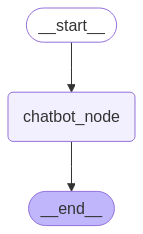

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import HumanMessage, AIMessage
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Nodes
def chat_model_node(state: State):
    # Return the LLM's response in the correct state format
    return {"messages": [llm.invoke(state["messages"])]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot_node", chat_model_node)

# Connecto nodes
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

We define the function to print the graph messages.

In [3]:
# Colors for the terminal
COLOR_GREEN = "\033[32m"
COLOR_YELLOW = "\033[33m"
COLOR_RESET = "\033[0m"


def stream_graph_updates(user_input: str, config: dict):
    # Initialize a flag to track if an assistant response has been printed
    assistant_response_printed = False

    # Print the user's input immediately
    print(f"\n\n{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
    
    # Create the user's message with the HumanMessage class
    user_message = HumanMessage(content=user_input)
    
    # Stream events from the graph execution
    for event in graph.stream({"messages": [user_message]}, config, stream_mode="values"):
        # event is a dictionary mapping node names to their output
        # Example: {'chatbot_node': {'messages': [...]}} or {'summarize_conversation_node': {'summary': '...'}}

        # Iterate through node name and its output
        for node_name, value in event.items():
            # Check if this event is from the chatbot node which should contain the assistant's reply
            if node_name == 'messages':
                # Ensure the output format is as expected (list of messages)
                if isinstance(value, list):
                    # Get the messages from the event
                    messages = value
                    # Ensure 'messages' is a non-empty list
                    if isinstance(messages, list) and messages:
                        # Get the last message (presumably the assistant's reply)
                        last_message = messages[-1]
                        # Ensure the message is an instance of AIMessage
                        if isinstance(last_message, AIMessage):
                            # Ensure the message has content to display
                            if hasattr(last_message, 'content'):
                                # Print the assistant's message content
                                print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}{last_message.content}")
                                assistant_response_printed = True # Mark that we've printed the response
    
    # Fallback if no assistant response was printed (e.g., graph error before chatbot_node)
    if not assistant_response_printed:
        print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}[No response generated or error occurred]")

We run the graph

In [4]:
USER1_THREAD_ID = "USER1"
config_USER1 = {"configurable": {"thread_id": USER1_THREAD_ID}}
while True:
    user_input = input(f"\n\nUser: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print(f"{COLOR_GREEN}User: {COLOR_RESET}Exiting...")
        print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}Goodbye!")
        break
    
    events = stream_graph_updates(user_input, config_USER1)



User: Hello, my name is Máximo
Assistant: Hello Máximo! It's a pleasure to meet you. How can I assist you today?
User: Exiting...
Assistant: Goodbye!


As you can see, I have only told you my name.

Now we restart the notebook to remove all data stored in the notebook's RAM and re-run the previous code.

We recreate the `sqlite` memory with `SqliteSaver`

In [1]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
import os

# Create the directory if it doesn't exist
os.makedirs("state_db", exist_ok=True)

db_path = "state_db/langgraph_sqlite.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)

We recreate the graph

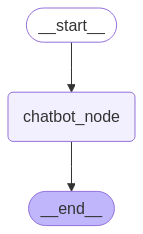

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import HumanMessage, AIMessage
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Nodes
def chat_model_node(state: State):
    # Return the LLM's response in the correct state format
    return {"messages": [llm.invoke(state["messages"])]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot_node", chat_model_node)

# Connecto nodes
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

We redefine the function to print the graph messages.

In [3]:
# Colors for the terminal
COLOR_GREEN = "\033[32m"
COLOR_YELLOW = "\033[33m"
COLOR_RESET = "\033[0m"


def stream_graph_updates(user_input: str, config: dict):
    # Initialize a flag to track if an assistant response has been printed
    assistant_response_printed = False

    # Print the user's input immediately
    print(f"\n\n{COLOR_GREEN}User: {COLOR_RESET}{user_input}")
    
    # Create the user's message with the HumanMessage class
    user_message = HumanMessage(content=user_input)
    
    # Stream events from the graph execution
    for event in graph.stream({"messages": [user_message]}, config, stream_mode="values"):
        # event is a dictionary mapping node names to their output
        # Example: {'chatbot_node': {'messages': [...]}} or {'summarize_conversation_node': {'summary': '...'}}

        # Iterate through node name and its output
        for node_name, value in event.items():
            # Check if this event is from the chatbot node which should contain the assistant's reply
            if node_name == 'messages':
                # Ensure the output format is as expected (list of messages)
                if isinstance(value, list):
                    # Get the messages from the event
                    messages = value
                    # Ensure 'messages' is a non-empty list
                    if isinstance(messages, list) and messages:
                        # Get the last message (presumably the assistant's reply)
                        last_message = messages[-1]
                        # Ensure the message is an instance of AIMessage
                        if isinstance(last_message, AIMessage):
                            # Ensure the message has content to display
                            if hasattr(last_message, 'content'):
                                # Print the assistant's message content
                                print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}{last_message.content}")
                                assistant_response_printed = True # Mark that we've printed the response
    
    # Fallback if no assistant response was printed (e.g., graph error before chatbot_node)
    if not assistant_response_printed:
        print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}[No response generated or error occurred]")

And we run it again

In [5]:
USER1_THREAD_ID = "USER1"
config_USER1 = {"configurable": {"thread_id": USER1_THREAD_ID}}
while True:
    user_input = input(f"\n\nUser: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print(f"{COLOR_GREEN}User: {COLOR_RESET}Exiting...")
        print(f"{COLOR_YELLOW}Assistant: {COLOR_RESET}Goodbye!")
        break
    
    events = stream_graph_updates(user_input, config_USER1)



User: What's my name?
Assistant: Your name is Máximo. It's nice to know and use your name as we chat. How can I assist you today, Máximo?
User: Exiting...
Assistant: Goodbye!


As can be seen, we have been able to recover the state of the graph from the SQLite database.

## Long-term memory, memory between threads

Memory is a cognitive function that allows people to store, retrieve, and use information to understand their present and future based on their past.

There are several types of [memory](https://langchain-ai.github.io/langgraph/concepts/memory) that can be used in AI applications.

### Introduction to LangGraph Memory Store

LangGraph provides the [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore), which is a way to save and retrieve long-term memory across different threads. This way, in a conversation, a user can indicate that they like something, and in another conversation, the chatbot can retrieve this information to generate a more personalized response.

This is a class for persistent key-value stores (`key`-`value`).

When objects are stored in memory, three things are needed:
* A `namespace` for the object, done through a `tuple`
* A unique `key`
* The `value` of the object

Let's see an example

In [1]:
import uuid
from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())

# The value needs to be a dictionary  
value = {"food_preference" : "I like pizza"}

# Save the memory
in_memory_store.put(namespace_for_memory, key, value)

The object `in_memory_store` that we have created has several [methods](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) and one of them is `search`, which allows us to search by `namespace`

In [3]:
# Search 
memories = in_memory_store.search(namespace_for_memory)
type(memories), len(memories)

(list, 1)

It's a list with a single value, which makes sense because we only stored one value, so let's take a look at it.

In [6]:
value = memories[0]
value.dict()

{'namespace': ['1', 'memories'],
 'key': '70006131-948a-4d7a-bdce-78351c44fc4d',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-05-11T07:24:31.462465+00:00',
 'updated_at': '2025-05-11T07:24:31.462468+00:00',
 'score': None}

We can see its `key` and its `value`

In [7]:
# The key, value
memories[0].key, memories[0].value

('70006131-948a-4d7a-bdce-78351c44fc4d', {'food_preference': 'I like pizza'})

We can also use the `get` method to obtain an object from memory based on its `namespace` and `key`.

In [8]:
# Get the memory by namespace and key
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'namespace': ['1', 'memories'],
 'key': '70006131-948a-4d7a-bdce-78351c44fc4d',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-05-11T07:24:31.462465+00:00',
 'updated_at': '2025-05-11T07:24:31.462468+00:00'}

Just like we used checkpoints for short-term memory, for long-term memory we are going to use `LangGraph Store`

### Chatbot with long-term memory

We created a basic chatbot, with long-term memory and short-term memory.

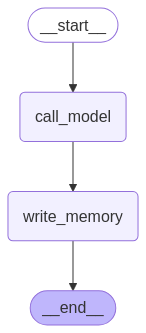

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver # Short-term memory
from langgraph.store.base import BaseStore          # Long-term memory
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.memory import InMemoryStore
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant that can answer questions and help with tasks.
You have access to a long-term memory that you can use to answer questions and help with tasks.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """You are a helpful assistant that gets information from the user to personalize your responses.

# INFORMATION FROM THE USER:
{memory}

# INSTRUCTIONS:
1. Carefully review the chat history
2. Identify new information from the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Combine any new information with the existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

# Nodes
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    # Extract the actual memory content if it exists and add a prefix
    if existing_memory:
        # Value is a dictionary with a memory key
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."
    if isinstance(existing_memory_content, str):
        print(f"\t[Call model debug] Existing memory: {existing_memory_content}")
    else:
        print(f"\t[Call model debug] Existing memory: {existing_memory_content.content}")

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)
    
    # Respond using memory as well as the chat history
    response = llm.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Extract the memory
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."
    if isinstance(existing_memory_content, str):
        print(f"\t[Write memory debug] Existing memory: {existing_memory_content}")
    else:
        print(f"\t[Write memory debug] Existing memory: {existing_memory_content.content}")

    # Format the memory in the system prompt
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = llm.invoke([SystemMessage(content=system_msg)]+state['messages'])
    if isinstance(new_memory, str):
        print(f"\n\t[Write memory debug] New memory: {new_memory}")
    else:
        print(f"\n\t[Write memory debug] New memory: {new_memory.content}")

    # Overwrite the existing memory in the store 
    key = "user_memory"

    # Write value as a dictionary with a memory key
    store.put(namespace, key, {"memory": new_memory.content})

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("call_model", call_model)
graph_builder.add_node("write_memory", write_memory)

# Connect nodes
graph_builder.add_edge(START, "call_model")
graph_builder.add_edge("call_model", "write_memory")
graph_builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
long_term_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
short_term_memory = MemorySaver()

# Compile the graph
graph = graph_builder.compile(checkpointer=short_term_memory, store=long_term_memory)

display(Image(graph.get_graph().draw_mermaid_png()))

Let's test it out.

In [2]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Maximo")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Maximo
	[Call model debug] Existing memory: No existing memory found.
================================== Ai Message ==================================

Hello Maximo! It's nice to meet you. How can I assist you today?
	[Write memory debug] Existing memory: No existing memory found.

	[Write memory debug] New memory:  

Here's the updated information I have about you:
- Name: Maximo


In [3]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
	[Call model debug] Existing memory:  

Here's the updated information I have about you:
- Name: Maximo
================================== Ai Message ==================================

That sounds like a great way to explore the city! San Francisco has some fantastic biking routes. Are there any specific areas or routes you enjoy biking the most, or are you looking for some new recommendations?
	[Write memory debug] Existing memory:  

Here's the updated information I have about you:
- Name: Maximo

	[Write memory debug] New memory:  

Here's the updated information about you:
- Name: Maximo
- Location: San Francisco
- Interest: Biking around San Francisco


If we recover long-term memory

In [4]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = long_term_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': " \n\nHere's the updated information about you:\n- Name: Maximo\n- Location: San Francisco\n- Interest: Biking around San Francisco"},
 'created_at': '2025-05-11T09:41:26.739207+00:00',
 'updated_at': '2025-05-11T09:41:26.739211+00:00'}

We get its value

In [10]:
print(existing_memory.value.get('memory'))

 

Here's the updated information about you:
- Name: Maximo
- Location: San Francisco
- Interest: Biking around San Francisco


Now we can start a new conversation thread, but with the same long-term memory. We will see that the chatbot remembers the user's information.

In [5]:
# We supply a user ID for across-thread memory as well as a new thread ID
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi! Where would you recommend that I go biking?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Where would you recommend that I go biking?
	[Call model debug] Existing memory:  

Here's the updated information about you:
- Name: Maximo
- Location: San Francisco
- Interest: Biking around San Francisco
================================== Ai Message ==================================

Hi there! Given my interest in biking around San Francisco, I'd recommend a few great routes:

1. **Golden Gate Park**: This is a fantastic place to bike, with wide paths that are separated from vehicle traffic. You can start at the eastern end near Stow Lake and bike all the way to the western end at Ocean Beach. There are plenty of scenic spots to stop and enjoy along the way.

2. **The Embarcadero**: This route follows the waterfront from Fisherman’s Wharf to the Bay Bridge. It’s relatively flat and offers beautiful views of the San Francisco Bay and the city skyline. You can also stop by the Ferry Building for som

I started a new conversation thread, I asked where I could go cycling, they remembered that I had told them I like to go cycling in San Francisco and responded with places in San Francisco that I could visit.

### Chatbot with user profile

> Note: We will be doing this section using Sonnet 3.7, as the HuggingFace integration does not have the `with_structured_output` functionality that provides a structured output with a defined structure.

We can create types so that the LLM generates an output with a structure defined by us.

Let's create a type definition for the user profile.

In [1]:
from typing import TypedDict, List

class UserProfile(TypedDict):
    """User profile schema with typed fields"""
    user_name: str  # The user's preferred name
    interests: List[str]  # A list of the user's interests

Now we recreate the graph, but this time with the `UserProfile` type.

We are going to use `with_structured_output` so that the LLM generates an output with a structure defined by us, and we will define that structure using the `Subjects` class, which is a `BaseModel` class from `Pydantic`.

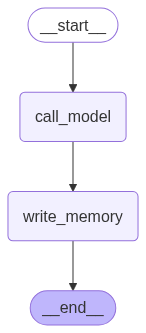

In [7]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver # Short-term memory
from langgraph.store.base import BaseStore          # Long-term memory
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.memory import InMemoryStore
from IPython.display import Image, display
from pydantic import BaseModel, Field
import os
import dotenv

dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)
llm_with_structured_output = llm.with_structured_output(UserProfile)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """Create or update a user profile memory based on the user's chat history. 
This will be saved for long-term memory. If there is an existing memory, simply update it. 
Here is the existing memory (it may be empty): {memory}"""

# Nodes
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
    # if isinstance(existing_memory_content, str):
    print(f"\t[Call model debug] Existing memory: {formatted_memory}")
    # else:
    #     print(f"\t[Call model debug] Existing memory: {existing_memory_content.content}")

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = llm.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
    print(f"\t[Write memory debug] Existing memory: {formatted_memory}")
        
    # Format the existing memory in the instruction
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    # Invoke the model to produce structured output that matches the schema
    new_memory = llm_with_structured_output.invoke([SystemMessage(content=system_msg)]+state['messages'])
    print(f"\t[Write memory debug] New memory: {new_memory}")

    # Overwrite the existing use profile memory
    key = "user_memory"
    store.put(namespace, key, new_memory)

# Create graph builder
graph_builder = StateGraph(MessagesState)

# Add nodes
graph_builder.add_node("call_model", call_model)
graph_builder.add_node("write_memory", write_memory)

# Connect nodes
graph_builder.add_edge(START, "call_model")
graph_builder.add_edge("call_model", "write_memory")
graph_builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
long_term_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
short_term_memory = MemorySaver()

# Compile the graph
graph = graph_builder.compile(checkpointer=short_term_memory, store=long_term_memory)

display(Image(graph.get_graph().draw_mermaid_png()))

We run the graph

In [8]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Maximo and I like to bike around Madrid and eat salads.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Maximo and I like to bike around Madrid and eat salads.
	[Call model debug] Existing memory: None
================================== Ai Message ==================================

Hello Maximo! It's nice to meet you. I see you enjoy biking around Madrid and eating salads - those are great healthy habits! Madrid has some beautiful areas to explore by bike, and the city has been improving its cycling infrastructure in recent years. 

Is there anything specific about Madrid's cycling routes or perhaps some good places to find delicious salads in the city that you'd like to know more about? I'd be happy to help with any questions you might have.
	[Write memory debug] Existing memory: None
	[Write memory debug] New memory: {'user_name': 'Maximo', 'interests': ['biking', 'Madrid', 'salads']}


As we can see, the LLM has generated an output with the structure defined by us.

Let's see how long-term memory has been stored.

In [9]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = long_term_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': 'Maximo', 'interests': ['biking', 'Madrid', 'salads']}

### More

#### Update Structured Schemas with Trustcall

In the previous example, we created user profiles with structured data

In fact, what happens under the hood is that the user profile is regenerated with each interaction. This generates an unnecessary expense of tokens and can lead to the loss of important user profile information.

So to solve it, we are going to use the [TrustCall](https://github.com/hinthornw/trustcall) library, which is an open source library for updating JSON schemas. When it needs to update a JSON schema, it does so incrementally, that is, it doesn't delete the previous schema, but rather adds the new fields.

Let's create a conversation example to see how it works.

In [1]:
from langchain_core.messages import HumanMessage, AIMessage

# Conversation
conversation = [HumanMessage(content="Hi, I'm Maximo."), 
                AIMessage(content="Nice to meet you, Maximo."), 
                HumanMessage(content="I really like playing soccer.")]

We create a structured schema and an LLM model

In [2]:
from pydantic import BaseModel, Field
from typing import List

# Schema
class UserProfile(BaseModel):
    """User profile schema with typed fields"""
    user_name: str = Field(description="The user's preferred name")
    interests: List[str] = Field(description="A list of the user's interests")

from langchain_anthropic import ChatAnthropic
import os
import dotenv

dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)

We use the `create_extractor` function from `trustcall` to create a structured data extractor

In [3]:
from trustcall import create_extractor

# Create the extractor
trustcall_extractor = create_extractor(
    llm,
    tools=[UserProfile],
    tool_choice="UserProfile"
)

As can be seen, the `trustcall_extractor` method is given an llm, which will be used as the search engine.

We extracted the structured data

In [4]:
from langchain_core.messages import SystemMessage

# Instruction
system_msg = "Extract the user profile from the following conversation"

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+conversation})
result

{'messages': [AIMessage(content=[{'id': 'toolu_01WfgbD1fG3rJYAXGrjqjfVY', 'input': {'user_name': 'Maximo', 'interests': ['soccer']}, 'name': 'UserProfile', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01TEB3FeDKLAeHJtbKo5noyW', 'model': 'claude-3-7-sonnet-20250219', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 497, 'output_tokens': 56}, 'model_name': 'claude-3-7-sonnet-20250219'}, id='run-8a15289b-fd39-4a2d-878a-fa6feaa805c5-0', tool_calls=[{'name': 'UserProfile', 'args': {'user_name': 'Maximo', 'interests': ['soccer']}, 'id': 'toolu_01WfgbD1fG3rJYAXGrjqjfVY', 'type': 'tool_call'}], usage_metadata={'input_tokens': 497, 'output_tokens': 56, 'total_tokens': 553, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})],
 'responses': [UserProfile(user_name='Maximo', interests=['soccer'])],
 'response_metadata': [{'id': 'toolu_01WfgbD1fG3rJYAXGrjqjfVY'}],
 'at

Let's take a look at the messages that have been generated to extract the structured data

In [5]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================

[{'id': 'toolu_01WfgbD1fG3rJYAXGrjqjfVY', 'input': {'user_name': 'Maximo', 'interests': ['soccer']}, 'name': 'UserProfile', 'type': 'tool_use'}]
Tool Calls:
  UserProfile (toolu_01WfgbD1fG3rJYAXGrjqjfVY)
 Call ID: toolu_01WfgbD1fG3rJYAXGrjqjfVY
  Args:
    user_name: Maximo
    interests: ['soccer']


The `UserProfile` schema has been updated with the new data.

In [6]:
schema = result["responses"]
schema

[UserProfile(user_name='Maximo', interests=['soccer'])]

As we can see, the schema is a list, let's check the data type of its only element

In [7]:
type(schema[0])

__main__.UserProfile

We can convert it to a dictionary with `model_dump`

In [8]:
schema[0].model_dump()

{'user_name': 'Maximo', 'interests': ['soccer']}

Thanks to giving `trustcall_extractor` an LLM, we can ask it what we want it to extract

Let's simulate that the conversation continues to see how the schema updates.

In [9]:
# Update the conversation
updated_conversation = [HumanMessage(content="Hi, I'm Maximo."), 
                AIMessage(content="Nice to meet you, Maximo."), 
                HumanMessage(content="I really like playing soccer."),
                AIMessage(content="It is great to play soccer! Where do you go after playing soccer?"),
                HumanMessage(content="I really like to go to a bakery after playing soccer."),]

We ask the model to update the schema (a `JSON`) using the `trustcall` library.

In [10]:
# Update the instruction
system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation}, 
                                    {"existing": {"UserProfile": schema[0].model_dump()}})
result

{'messages': [AIMessage(content=[{'id': 'toolu_01K1zTh33kXDAw1h18Yh2HBb', 'input': {'user_name': 'Maximo', 'interests': ['soccer', 'bakeries']}, 'name': 'UserProfile', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01RYUJvCdzL4b8kBYKo4BtQf', 'model': 'claude-3-7-sonnet-20250219', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 538, 'output_tokens': 60}, 'model_name': 'claude-3-7-sonnet-20250219'}, id='run-06994472-5ba0-46cc-a512-5fcacce283fc-0', tool_calls=[{'name': 'UserProfile', 'args': {'user_name': 'Maximo', 'interests': ['soccer', 'bakeries']}, 'id': 'toolu_01K1zTh33kXDAw1h18Yh2HBb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 538, 'output_tokens': 60, 'total_tokens': 598, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})],
 'responses': [UserProfile(user_name='Maximo', interests=['soccer', 'bakeries'])],
 'response_metadata': [{'id': 'too

Let's take a look at the messages that have been generated to update the schema

In [11]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================

[{'id': 'toolu_01K1zTh33kXDAw1h18Yh2HBb', 'input': {'user_name': 'Maximo', 'interests': ['soccer', 'bakeries']}, 'name': 'UserProfile', 'type': 'tool_use'}]
Tool Calls:
  UserProfile (toolu_01K1zTh33kXDAw1h18Yh2HBb)
 Call ID: toolu_01K1zTh33kXDAw1h18Yh2HBb
  Args:
    user_name: Maximo
    interests: ['soccer', 'bakeries']


We see the updated schema

In [12]:
updated_schema = result["responses"][0]
updated_schema.model_dump()

{'user_name': 'Maximo', 'interests': ['soccer', 'bakeries']}

#### Chatbot with updated user profile using Trustcall

We recreate the graph that updates the user profile, but now with the `trustcall` library.

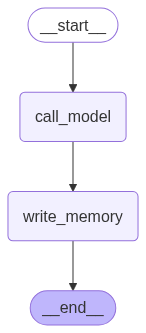

In [1]:

from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver # Short-term memory
from langgraph.store.base import BaseStore          # Long-term memory
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.memory import InMemoryStore
from IPython.display import Image, display
from pydantic import BaseModel, Field
import os
import dotenv
from trustcall import create_extractor

dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Schema 
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

# Create the LLM model
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)

# Create the extractor
trustcall_extractor = create_extractor(
    llm,
    tools=[UserProfile],
    tool_choice="UserProfile", # Enforces use of the UserProfile tool
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

# Nodes
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"      
        )
    else:
        formatted_memory = None
    print(f"\t[Call model debug] Existing memory: {formatted_memory}")

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = llm.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None
    print(f"\t[Write memory debug] Existing profile: {existing_profile}")
    
    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})
    
    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()
    print(f"\t[Write memory debug] Updated profile: {updated_profile}")

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)

# Create graph builder
graph_builder = StateGraph(MessagesState)

# Add nodes
graph_builder.add_node("call_model", call_model)
graph_builder.add_node("write_memory", write_memory)

# Connect nodes
graph_builder.add_edge(START, "call_model")
graph_builder.add_edge("call_model", "write_memory")
graph_builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
long_term_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
short_term_memory = MemorySaver()

# Compile the graph
graph = graph_builder.compile(checkpointer=short_term_memory, store=long_term_memory)

display(Image(graph.get_graph().draw_mermaid_png()))

We start the conversation

In [2]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Maximo")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Maximo
	[Call model debug] Existing memory: None
================================== Ai Message ==================================

Hello Maximo! It's nice to meet you. How can I help you today? Whether you have questions, need information, or just want to chat, I'm here to assist you. Is there something specific you'd like to talk about?
	[Write memory debug] Existing profile: None
	[Write memory debug] Updated profile: {'user_name': 'Maximo', 'user_location': '<UNKNOWN>', 'interests': []}


As we can see, it doesn't know the user's location or interests. Let's update the user's profile.

In [3]:
# User input 
input_messages = [HumanMessage(content="I like to play soccer and I live in Madrid")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to play soccer and I live in Madrid
	[Call model debug] Existing memory: Name: Maximo
Location: <UNKNOWN>
Interests: 
================================== Ai Message ==================================

Hello Maximo! It's great to learn that you live in Madrid and enjoy playing soccer. Madrid is a fantastic city with a rich soccer culture, being home to world-famous clubs like Real Madrid and Atlético Madrid.

Soccer is truly a way of life in Spain, so you're in a perfect location for your interest. Do you support any particular team in Madrid? Or perhaps you enjoy playing soccer recreationally in the city's parks and facilities?

Is there anything specific about Madrid or soccer you'd like to discuss further?
	[Write memory debug] Existing profile: {'UserProfile': {'user_name': 'Maximo', 'user_location': '<UNKNOWN>', 'interests': []}}
	[Write memory debug] Updated profile: {'user_name': 'Maximo', 'us

You have updated the profile with the user's location and interests.

Let's check the updated memory

In [4]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = long_term_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'user_name': 'Maximo',
  'user_location': 'Madrid',
  'interests': ['soccer']},
 'created_at': '2025-05-12T17:35:03.583258+00:00',
 'updated_at': '2025-05-12T17:35:03.583259+00:00'}

We see the schema with the user profile updated

In [5]:
# The user profile saved as a JSON object
existing_memory.value

{'user_name': 'Maximo', 'user_location': 'Madrid', 'interests': ['soccer']}

Let's add a new user interest

In [6]:
# User input 
input_messages = [HumanMessage(content="I also like to play basketball")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also like to play basketball
	[Call model debug] Existing memory: Name: Maximo
Location: Madrid
Interests: soccer
================================== Ai Message ==================================

That's great to know, Maximo! It's nice that you enjoy both soccer and basketball. Basketball is also quite popular in Spain, with Liga ACB being one of the strongest basketball leagues in Europe. 

In Madrid, you have the opportunity to follow Real Madrid's basketball section, which is one of the most successful basketball teams in Europe. The city offers plenty of courts and facilities where you can play basketball too.

Do you play basketball casually with friends, or are you part of any local leagues in Madrid? And how do you balance your time between soccer and basketball?
	[Write memory debug] Existing profile: {'UserProfile': {'user_name': 'Maximo', 'user_location': 'Madrid', 'interests': ['soccer']}}
	[

We review the updated memory.

In [7]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = long_term_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': 'Maximo',
 'user_location': 'Madrid',
 'interests': ['soccer', 'basketball']}

It has correctly added the new user interest.

With this long-term memory stored, we can start a new thread and the chatbot will have access to our updated profile.

In [8]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What soccer players do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What soccer players do you recommend for me?
	[Call model debug] Existing memory: Name: Maximo
Location: Madrid
Interests: soccer, basketball
================================== Ai Message ==================================

Based on your interest in soccer, I can recommend some players who might appeal to you. Since you're from Madrid, you might already follow Real Madrid or Atlético Madrid players, but here are some recommendations:

From La Liga:
- Vinícius Júnior and Jude Bellingham (Real Madrid)
- Antoine Griezmann (Atlético Madrid)
- Robert Lewandowski (Barcelona)
- Lamine Yamal (Barcelona's young talent)

International stars:
- Kylian Mbappé
- Erling Haaland
- Mohamed Salah
- Kevin De Bruyne

You might also enjoy watching players with creative playing styles since you're interested in basketball as well, which is a sport that values creativity and flair - players like Rodrigo De Paul or João Félix.


Since it knows I live in Madrid, it first suggested Spanish La Liga football players. And then it suggested players from other leagues.

#### Chatbot with user document collections updated with Trustcall

Another approach is to store a collection of documents instead of saving the user profile in a single document. This way, we are not tied to a single closed schema.

Let's see how to do it

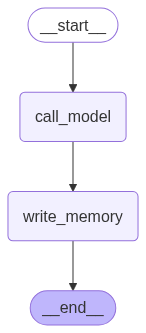

In [1]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.messages import merge_message_runs
from langgraph.checkpoint.memory import MemorySaver # Short-term memory
from langgraph.store.base import BaseStore          # Long-term memory
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.memory import InMemoryStore
from IPython.display import Image, display
from trustcall import create_extractor
from pydantic import BaseModel, Field
import uuid
import os
import dotenv

dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Memory schema
class Memory(BaseModel):
    """A memory item representing a piece of information learned about the user."""
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

# Create the LLM model
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)

# Create the extractor
trustcall_extractor = create_extractor(
    llm,
    tools=[Memory],
    tool_choice="Memory",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. You are designed to be a companion to a user. 
You have a long term memory which keeps track of information you learn about the user over time.
Current Memory (may include updated memories from this conversation): 
{memory}"""

# Create new memory from the chat history and any existing memory
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 
Use the provided tools to retain any necessary memories about the user. 
Use parallel tool calling to handle updates and insertions simultaneously:"""

# Nodes
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)
    print(f"\t[Call model debug] Memories: {memories}")

    # Format the memories for the system prompt
    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)

    # Respond using memory as well as the chat history
    response = llm.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Memory"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )
    print(f"\t[Write memory debug] Existing memories: {existing_memories}")

    # Merge the chat history and the instruction
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]))

    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": updated_messages, 
                                        "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    print(f"\t[Write memory debug] Saved memories: {result['responses']}")

# Create graph builder
graph_builder = StateGraph(MessagesState)

# Add nodes
graph_builder.add_node("call_model", call_model)
graph_builder.add_node("write_memory", write_memory)

# Connect nodes
graph_builder.add_edge(START, "call_model")
graph_builder.add_edge("call_model", "write_memory")
graph_builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
long_term_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
short_term_memory = MemorySaver()

# Compile the graph
graph = graph_builder.compile(checkpointer=short_term_memory, store=long_term_memory)

display(Image(graph.get_graph().draw_mermaid_png()))

We start a new conversation

In [2]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Maximo")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Maximo
	[Call model debug] Memories: []
================================== Ai Message ==================================

Hello Maximo! It's nice to meet you. I'm your companion chatbot, here to chat, help answer questions, or just be someone to talk to. 

I'll remember your name is Maximo for our future conversations. What would you like to talk about today? How are you doing?
	[Write memory debug] Existing memories: None
	[Write memory debug] Saved memories: [Memory(content="User's name is Maximo.")]


We add a new user interest

In [3]:
# User input 
input_messages = [HumanMessage(content="I like to play soccer")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to play soccer
	[Call model debug] Memories: [Item(namespace=['memories', '1'], key='6d06c4f5-3a74-46b2-92b4-1e29ba128c90', value={'content': "User's name is Maximo."}, created_at='2025-05-12T18:32:38.070902+00:00', updated_at='2025-05-12T18:32:38.070903+00:00', score=None)]
================================== Ai Message ==================================

That's great to know, Maximo! Soccer is such a wonderful sport. Do you play on a team, or more casually with friends? I'd also be curious to know what position you typically play, or if you have a favorite professional team you follow. I'll remember that you enjoy soccer for our future conversations.
	[Write memory debug] Existing memories: [('6d06c4f5-3a74-46b2-92b4-1e29ba128c90', 'Memory', {'content': "User's name is Maximo."})]
	[Write memory debug] Saved memories: [Memory(content='User enjoys playing soccer.')]


As we can see, the user's new interest has been added to the memory.

Let's check the updated memory

In [5]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)
memories = long_term_memory.search(namespace)
for m in memories:
    print(m.dict())

{'namespace': ['memories', '1'], 'key': '6d06c4f5-3a74-46b2-92b4-1e29ba128c90', 'value': {'content': "User's name is Maximo."}, 'created_at': '2025-05-12T18:32:38.070902+00:00', 'updated_at': '2025-05-12T18:32:38.070903+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': '25d2ee8c-5890-415b-85e0-d9fb0ea4cd43', 'value': {'content': 'User enjoys playing soccer.'}, 'created_at': '2025-05-12T18:32:42.558787+00:00', 'updated_at': '2025-05-12T18:32:42.558789+00:00', 'score': None}


In [6]:
for m in memories:
    print(m.value)

{'content': "User's name is Maximo."}
{'content': 'User enjoys playing soccer.'}


We see that memory documents are saved, not a user profile.

Let's add a new user interest

In [7]:
# User input 
input_messages = [HumanMessage(content="I also like to play basketball")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also like to play basketball
	[Call model debug] Memories: [Item(namespace=['memories', '1'], key='6d06c4f5-3a74-46b2-92b4-1e29ba128c90', value={'content': "User's name is Maximo."}, created_at='2025-05-12T18:32:38.070902+00:00', updated_at='2025-05-12T18:32:38.070903+00:00', score=None), Item(namespace=['memories', '1'], key='25d2ee8c-5890-415b-85e0-d9fb0ea4cd43', value={'content': 'User enjoys playing soccer.'}, created_at='2025-05-12T18:32:42.558787+00:00', updated_at='2025-05-12T18:32:42.558789+00:00', score=None)]
================================== Ai Message ==================================

That's awesome, Maximo! Both soccer and basketball are fantastic sports. I'll remember that you enjoy basketball as well. Do you find yourself playing one more than the other? And similar to soccer, do you play basketball with a team or more casually? Many people enjoy the different skills and dynamics each 

We revisit the updated memory.

In [8]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)
memories = long_term_memory.search(namespace)
for m in memories:
    print(m.value)

{'content': "User's name is Maximo."}
{'content': 'User enjoys playing soccer.'}
{'content': 'User enjoys playing basketball.'}


We start a new conversation with a new thread

In [9]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What soccer players do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What soccer players do you recommend for me?
	[Call model debug] Memories: [Item(namespace=['memories', '1'], key='6d06c4f5-3a74-46b2-92b4-1e29ba128c90', value={'content': "User's name is Maximo."}, created_at='2025-05-12T18:32:38.070902+00:00', updated_at='2025-05-12T18:32:38.070903+00:00', score=None), Item(namespace=['memories', '1'], key='25d2ee8c-5890-415b-85e0-d9fb0ea4cd43', value={'content': 'User enjoys playing soccer.'}, created_at='2025-05-12T18:32:42.558787+00:00', updated_at='2025-05-12T18:32:42.558789+00:00', score=None), Item(namespace=['memories', '1'], key='965f2e52-bea0-44d4-8534-4fce2bbc1c4b', value={'content': 'User enjoys playing basketball.'}, created_at='2025-05-12T18:33:38.613626+00:00', updated_at='2025-05-12T18:33:38.613629+00:00', score=None)]
================================== Ai Message ==================================

Hi Maximo! Since you enjoy soccer, I'd be happy to recom

We see that it was remembered that we liked football and basketball.

## Human in the loop

Although an agent can perform tasks, for certain tasks, human supervision is necessary. This is called `human in the loop`. So let's see how this can be done with `LangGraph`.

The [persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/) layer of `LangGraph` supports workflows with humans in the loop, allowing execution to pause and resume based on user feedback. The main interface for this functionality is the [interrupt](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#interrupt) function. Calling `interrupt` within a node will stop the execution. Execution can be resumed, along with the new human contribution, passed in a [Command](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#the-command-primitive) primitive. `interrupt` is similar to the Python `input()` command, but with some additional considerations.

Let's add to the chatbot short-term memory and access to tools, but we'll make a change by adding a simple tool `human_assistance`. This tool uses `interrupt` to receive information from a human.

First we load the values of the API keys

In [1]:
import os
import dotenv

dotenv.load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

We create the graph

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

We define the `tool` for searching

In [3]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
search_tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)

Now we create the `tool` for human assistance

In [4]:
from langgraph.types import Command, interrupt
from langchain_core.tools import tool

@tool
def human_assistance(query: str) -> str:
    """
    Request assistance from a human expert. Use this tool ONLY ONCE per conversation.
    After receiving the expert's response, you should provide an elaborated response to the user based on the information received
    based on the information received, without calling this tool again.

    Args:
        query: The query to ask the human expert.

    Returns:
        The response from the human expert.
    """
    human_response = interrupt({"query": query})
    return human_response["data"]

`LangGraph` obtains information about the tools from the tool's documentation, that is, the function's `docstring`. Therefore, it is very important to generate a good `docstring` for the tool.

We create a list of `tools`

In [5]:
tools_list = [search_tool, human_assistance]

Next, the `LLM` with the `bind_tools` and we add it to the graph

In [6]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM
login(token=HUGGINGFACE_TOKEN)
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)

If you notice, we have changed the way we define the function `chatbot_function`, as it now has to handle the interruption.

We add the `tool_node` to the graph

In [7]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=tools_list)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")

We add the `START` node to the graph

In [8]:
graph_builder.add_edge(START, "chatbot_node")

We create a `checkpointer` [MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver).

In [9]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

We compile the graph with the `checkpointer`

In [10]:
graph = graph_builder.compile(checkpointer=memory)

We represent it graphically

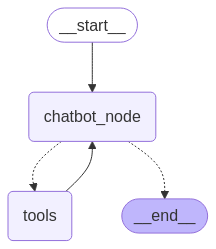

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Now let's ask the chatbot a question that will involve the new `human_assistance` tool:

In [12]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (0)
 Call ID: 0
  Args:
    query: I need some expert guidance for building an AI agent. Could you provide me with some advice?


As can be seen, the chatbot generated a call to the human assistance tool.

``` markdown
Tool Calls:
human_assistance (0)
Call ID: 0
Args:
I need some expert guidance for building an AI agent. Could you provide advice on key considerations, best practices, and potential pitfalls to avoid?
```

But then the execution was interrupted. Let's check the status of the graph.

In [13]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

We see that it stopped at the `tools` node. We analyze how the `human_assistance` tool has been defined.

``` python
from langgraph.types import Command, interrupt
from langchain_core.tools import tool

@tool
def human_assistance(query: str) -> str:
    """
    Request assistance from a human expert. Use this tool ONLY ONCE per conversation.
    After receiving the expert's response, you should provide an elaborated response to the user based on the information received
    based on the information received, without calling this tool again.

    Args:
        query: The query to ask the human expert.

    Returns:
        The response from the human expert.
    """
    human_response = interrupt({"query": query})
    return human_response["data"]
```

Calling the `interrupt` tool will stop the execution, similar to the Python `input()` function.

Progress is maintained based on our choice of [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries). That is, the choice of where the graph state is saved. So if we are persisting (saving the graph state) with a database like `SQLite`, `Postgres`, etc., we can resume execution at any time as long as the database is alive.

Here we are persisting (saving the state of the graph) with the checkpoint pointer in memory RAM, so we can resume at any time while our Python kernel is running. In my case, as long as I don't reset the kernel of my Jupyter Notebook.

To resume execution, we pass a [Command](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#the-command-primitive) object that contains the data expected by the tool. The format of this data can be customized based on our needs. Here, we only need a dictionary with a `data` key.

In [14]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    "It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (0)
 Call ID: 0
  Args:
    query: I need some expert guidance for building an AI agent. Could you provide me with some advice?
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent.It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts recommend checking out LangGraph for building your AI agent. It's known for being more reliable and extensible compared to simple autonomous agents.


As we can see, the chatbot has waited for a human to provide the answer and then generated a response based on the received information. We asked for help from an expert on how to create agents, the human told it that the best option is to use LangGraph, and the chatbot generated a response based on that information.

But it still has the ability to perform web searches. So now we're going to ask for the latest news about LangGraph.

In [15]:
user_input = "What's the latest news about LangGraph?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What's the latest news about LangGraph?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (0)
 Call ID: 0
  Args:
    query: latest news LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangChain - Changelog", "url": "https://changelog.langchain.com/", "content": "LangGraph `interrupt`: Simplifying human-in-the-loop agents --------------------------------------------------- Our latest feature in LangGraph, interrupt , makes building human-in-the-loop workflows easier. Agents aren’t perfect, so keeping humans “in the loop”... December 16, 2024 [...] LangGraph 🔁 Modify graph state from tools in LangGraph --------------------------------------------- LangGraph's latest update gives you greater control over your agents by enabling tools to directly upd

He has looked for the latest news about LangGraph and has generated a response based on the information received.

Let's write everything together so it is more understandable

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login

from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt
from langchain_core.tools import tool

from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display
import json

import os
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

import dotenv
dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Tools
wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
tool_search = TavilySearchResults(api_wrapper=wrapper, max_results=2)

@tool
def human_assistance(query: str) -> str:
    """
    Request assistance from a human expert. Use this tool ONLY ONCE per conversation.
    After receiving the expert's response, you should provide an elaborated response to the user based on the information received
    based on the information received, without calling this tool again.

    Args:
        query: The query to ask the human expert.

    Returns:
        The response from the human expert.
    """
    human_response = interrupt({"query": query})
    return human_response["data"]

tools_list = [tool_search, human_assistance]

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)
# Create the LLM with tools
llm_with_tools = llm.bind_tools(tools_list)

# Tool node
tool_node = ToolNode(tools=tools_list)

# Functions
def chatbot_function(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

# Start to build the graph
graph_builder = StateGraph(State)

# Add nodes to the graph
graph_builder.add_node("chatbot_node", chatbot_function)
graph_builder.add_node("tools", tool_node)

# Add edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_conditional_edges( "chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")

# Compile the graph
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Display the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Error al visualizar el grafo: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`


We ask the chatbot for help again to create agents. We request that it seek assistance.

In [2]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (0)
 Call ID: 0
  Args:
    query: I need expert guidance for building an AI agent.


We see in what state the graph has been left

In [3]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

We provide the assistance you are requesting.

In [4]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    "It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (0)
 Call ID: 0
  Args:
    query: I need expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent.It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================
Tool Calls:
  human_assistance (0)
 Call ID: 0
  Args:
    query: I need some expert guidance for building an AI agent. Could you recommend a platform and any tips for getting started?


And lastly, we ask you to search the internet for the latest news about LangGraph

In [5]:
user_input = "What's the latest news about LangGraph?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

What's the latest news about LangGraph?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (0)
 Call ID: 0
  Args:
    query: latest news about LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangChain Blog", "url": "https://blog.langchain.dev/", "content": "LangSmith Incident on May 1, 2025\n\nRequests to the US LangSmith API from both the web application and SDKs experienced an elevated error rate for 28 minutes on May 1, 2025\n\nFeatured\n\nHow Klarna's AI assistant redefined customer support at scale for 85 million active users\n\nIs LangGraph Used In Production?\n\nIntroducing Interrupt: The AI Agent Conference by LangChain\n\nTop 5 LangGraph Agents in Production 2024 [...] See how Harmonic uses LangSmith and LangGraph products to streamline v

### More

#### Approval of tool usage

> Note: We are going to use Sonnet 3.7 for this section, as at the time of writing the post, it is the best model for use with agents, and it is the only one that understands when to call the tools and when not to for this example

We can add a `human in the loop` to approve the use of tools. We are going to create a chatbot with several tools for performing mathematical operations, so when building the graph we specify where we want to insert the `breakpoint` (`graph_builder.compile(interrupt_before=["tools"], checkpointer=memory)`)

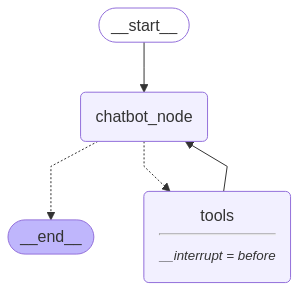

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from langchain_anthropic import ChatAnthropic
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

memory = MemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int

    Returns:
        The product of a and b.
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int

    Returns:
        The sum of a and b.
    """
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract b from a.

    Args:
        a: first int
        b: second int

    Returns:
        The difference between a and b.
    """
    return a - b

@tool
def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int

    Returns:
        The quotient of a and b.
    """
    return a / b

tools_list = [multiply, add, subtract, divide]

# Create the LLM model
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)
llm_with_tools = llm.bind_tools(tools_list)

# Nodes
def chat_model_node(state: State):
    system_message = "You are a helpful assistant that can use tools to answer questions. Once you have the result of a tool, provide a final answer without calling more tools."
    messages = [SystemMessage(content=system_message)] + state["messages"]
    return {"messages": [llm_with_tools.invoke(messages)]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot_node", chat_model_node)
tool_node = ToolNode(tools=tools_list)
graph_builder.add_node("tools", tool_node)

# Connecto nodes
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile(interrupt_before=["tools"], checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

As we can see in the graph, there is an `interrupt` before using the `tool`s. This means it will stop before using them to ask for our permission.

In [2]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, config, stream_mode="updates"):
    if 'chatbot_node' in event:
        print(event['chatbot_node']['messages'][-1].pretty_print())
    else:
        print(event)

================================== Ai Message ==================================

[{'text': "I'll multiply 2 and 3 for you.", 'type': 'text'}, {'id': 'toolu_01QDuind1VBHWtvifELN9SPf', 'input': {'a': 2, 'b': 3}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_01QDuind1VBHWtvifELN9SPf)
 Call ID: toolu_01QDuind1VBHWtvifELN9SPf
  Args:
    a: 2
    b: 3
None
{'__interrupt__': ()}


As we can see, the LLM knows it has to use the `multiply` tool, but the execution is interrupted because it has to wait for a human to authorize the use of the tool.

We can see the state in which the graph has been left.

In [3]:
state = graph.get_state(config)
state.next

('tools',)

As we can see, it has remained on the `tools` node.

We can create a function (not in the graph, but outside the graph, to improve the user experience and help them understand why execution pauses) that asks the user to approve the use of the tool.

We create a new `thread_id` so that a new state is created.

In [51]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

config = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, config, stream_mode="updates"):
    function_name = None
    function_args = None

    if 'chatbot_node' in event:
        for element in event['chatbot_node']['messages'][-1].content:
            if element['type'] == 'text':
                print(element['text'])
            elif element['type'] == 'tool_use':
                function_name = element['name']
                function_args = element['input']
                print(f"The LLM wants to use the tool {function_name} with the arguments {function_args}")
    
    elif '__interrupt__' in event:
        pass
    
    else:
        print(event)

question = f"Do you approve the use of the tool {function_name} with the arguments {function_args}? (y/n)"
user_approval = input(question)
print(f"{question}: {user_approval}")

if user_approval.lower() == 'y':
    print("User approved the use of the tool")
    for event in graph.stream(None, config, stream_mode="updates"):
        if 'chatbot_node' in event:
            for element in event['chatbot_node']['messages'][-1].content:
                if isinstance(element, str):
                    print(element, end="")
        
        elif 'tools' in event:
            result = event['tools']['messages'][-1].content
            tool_used = event['tools']['messages'][-1].name
            print(f"The result of the tool {tool_used} is {result}")
        
        else:
            print(event)


I'll multiply 2 and 3 for you.
The LLM wants to use the tool multiply with the arguments {'a': 2, 'b': 3}
Do you approve the use of the tool None with the arguments None? (y/n): y
User approved the use of the tool
The result of the tool multiply is 6
The result of multiplying 2 and 3 is 6.

We can see that it has asked us if we approve the use of the `tool` for multiplication, we have approved it and the graph has finished execution. Looking at the state of the graph.

In [52]:
state = graph.get_state(config)
state.next

()

We see that the next state of the graph is empty, which indicates that the graph execution has finished.

#### State Modification

> Note: We are going to use Sonnet 3.7 for this section, as at the time of writing the post, it is the best model for use with agents, and it is the only one that understands when it needs to call the tools and when it does not for this example

Let's repeat the previous example, but instead of interrupting the graph before the use of a `tool`, we will interrupt it at the LLM. To do this, when building the graph, we specify that we want to stop at the agent (`graph_builder.compile(interrupt_before=["chatbot_node"], checkpointer=memory)`)

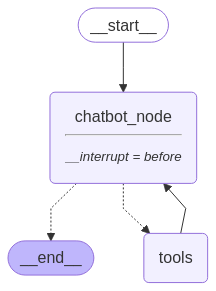

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from langchain_anthropic import ChatAnthropic
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

memory = MemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int

    Returns:
        The product of a and b.
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int

    Returns:
        The sum of a and b.
    """
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Subtract b from a.

    Args:
        a: first int
        b: second int

    Returns:
        The difference between a and b.
    """
    return a - b

@tool
def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int

    Returns:
        The quotient of a and b.
    """
    return a / b

tools_list = [multiply, add, subtract, divide]

# Create the LLM model
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)
llm_with_tools = llm.bind_tools(tools_list)

# Nodes
def chat_model_node(state: State):
    system_message = "You are a helpful assistant that can use tools to answer questions. Once you have the result of a tool, provide a final answer without calling more tools."
    messages = [SystemMessage(content=system_message)] + state["messages"]
    return {"messages": [llm_with_tools.invoke(messages)]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot_node", chat_model_node)
tool_node = ToolNode(tools=tools_list)
graph_builder.add_node("tools", tool_node)

# Connecto nodes
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile(interrupt_before=["chatbot_node"], checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

We see in the graph representation that there is an `interrupt` before the execution of `chatbot_node`, so before the chatbot executes, the execution will be interrupted and we will have to make it continue.

Now we ask for a multiplication again

In [2]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, config, stream_mode="updates"):
    if 'chatbot_node' in event:
        print(event['chatbot_node']['messages'][-1].pretty_print())
    else:
        print(event)

{'__interrupt__': ()}


We can see that it has done nothing. If we check the status

In [4]:
state = graph.get_state(config)
state.next

('chatbot_node',)

We see that the next node is the chatbot node. Additionally, if we look at its values, we see the message that we have sent.

In [6]:
state.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='08fd6084-ecd2-4156-ab24-00d2d5c26f00')]}

Now we proceed to modify the state by adding a new message

In [7]:
graph.update_state(
    config,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]}
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f027eb6-6c8b-6b6a-8001-bc0f8942566c'}}

We get the new state

In [10]:
new_state = graph.get_state(config)
new_state.next

('chatbot_node',)

The following node is still the chatbot's, but if we now look at the messages

In [11]:
new_state.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='08fd6084-ecd2-4156-ab24-00d2d5c26f00'),
  HumanMessage(content='No, actually multiply 3 and 3!', additional_kwargs={}, response_metadata={}, id='e95394c2-e62e-47d2-b9b2-51eba40f3e22')]}

We see that the new one has been added. So we make it continue the execution.

In [13]:
for event in graph.stream(None, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================

[{'text': "I'll multiply 3 and 3 for you.", 'type': 'text'}, {'id': 'toolu_01UABhLnEdg5ZqxVQTE5pGUx', 'input': {'a': 3, 'b': 3}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_01UABhLnEdg5ZqxVQTE5pGUx)
 Call ID: toolu_01UABhLnEdg5ZqxVQTE5pGUx
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


The multiplication of 3 by 3 has been done, which is the state modification we made, and not 2 by 3, which is what we asked for the first time.

This can be useful when we have an agent and want to review that what it does is correct, so we can enter the execution and modify the state

#### Dynamic breakpoints

So far we have created static breakpoints through the graph compilation, but we can create dynamic breakpoints using `NodeInterrupt`. This is useful because execution can be interrupted by logical rules introduced through programming.

These `NodeInterrupt` allow customizing how the user will be notified of the interruption.

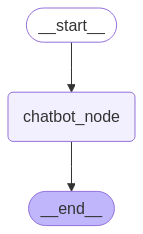

In [9]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from huggingface_hub import login
from IPython.display import Image, display
import os
import dotenv

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")

memory_saver = MemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]

os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

# Create the LLM model
login(token=HUGGINGFACE_TOKEN)  # Login to HuggingFace to use the model
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Nodes
def chatbot_function(state: State):
    max_len = 15
    input_message = state["messages"][-1]

    # Check len message
    if len(input_message.content) > max_len:
        raise NodeInterrupt(f"Received input is longer than {max_len} characters --> {input_message}")

    # Invoke the LLM with the messages
    response = llm.invoke(state["messages"])

    # Return the LLM's response in the correct state format
    return {"messages": [response]}

# Create graph builder
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot_node", chatbot_function)

# Connecto nodes
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_edge("chatbot_node", END)

# Compile the graph
graph = graph_builder.compile(checkpointer=memory_saver)

display(Image(graph.get_graph().draw_mermaid_png()))

As you can see, we have created an interruption in case the message is long. Let's test it.

In [10]:
initial_input = {"messages": HumanMessage(content="Hello, how are you? My name is Máximo")}

config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, config, stream_mode="updates"):
    if 'chatbot_node' in event:
        print(event['chatbot_node']['messages'][-1].pretty_print())
    else:
        print(event)

{'__interrupt__': (Interrupt(value="Received input is longer than 15 characters --> content='Hello, how are you? My name is Máximo' additional_kwargs={} response_metadata={} id='2bdc6d41-0cfe-4d3c-8748-ca7d46fd5a60'", resumable=False, ns=None),)}


Indeed, the interruption has stopped and it has given us the error message that we created.

If we look at the node where it has stopped

In [11]:
state = graph.get_state(config)
state.next

('chatbot_node',)

We see that it is stuck at the chatbot node. We can make it continue with the execution again, but it will give us the same error.

In [12]:
for event in graph.stream(None, config, stream_mode="updates"):
    if 'chatbot_node' in event:
        print(event['chatbot_node']['messages'][-1].pretty_print())
    else:
        print(event)

{'__interrupt__': (Interrupt(value="Received input is longer than 15 characters --> content='Hello, how are you? My name is Máximo' additional_kwargs={} response_metadata={} id='2bdc6d41-0cfe-4d3c-8748-ca7d46fd5a60'", resumable=False, ns=None),)}


So we have to modify the state

In [13]:
graph.update_state(
    config,
    {"messages": [HumanMessage(content="How are you?")]}
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f027f13-5827-6a18-8001-4209d5a866f0'}}

We revisit the state and its values

In [15]:
new_state = graph.get_state(config)
print(f"Siguiente nodo: {new_state.next}")
print("Valores:")
for value in new_state.values["messages"]:
    print(f"\t{value.content}")

Siguiente nodo: ('chatbot_node',)
Valores:
	Hello, how are you? My name is Máximo
	How are you?


The last message is shorter, so we tried to resume the execution of the graph

In [16]:
for event in graph.stream(None, config, stream_mode="updates"):
    if 'chatbot_node' in event:
        print(event['chatbot_node']['messages'][-1].pretty_print())
    else:
        print(event)

================================== Ai Message ==================================

Hello Máximo! I'm doing well, thank you for asking. How about you? How can I assist you today?
None


## Customization of the state

> Note: We will be using Sonnet 3.7 for this section, as at the time of writing the post, it is the best model for use with agents, and it is the only one that understands when to call the tools and when not to.

So far, we have relied on a simple state with an input and a list of messages. You can get quite far with this simple state, but if you want to define more complex behavior without relying on the message list, you can add additional fields to the state.

Here we are going to see a new scenario, in which the chatbot is using the search tool to find specific information, and forwarding it to a human for review. We will make the chatbot investigate the birthday of an entity. We will add `name` and `birthday` as state keys.

First we load the values of the API keys

In [1]:
import os
import dotenv

dotenv.load_dotenv()

TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

We create the new state

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

Adding this information to the state makes it easily accessible by other nodes of the graph (for example, a node that stores or processes the information), as well as the graph's persistence layer.

Now we create the graph

In [3]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

We define the `tool` for search

In [4]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
search_tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)

Now we create the human assistance tool. In this tool, we will fill in the state keys within our `human_assistance` tool. This allows a human to review the information before it is stored in the state. We will use `Command` again, this time to emit a state update from inside our tool.

In [5]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt


@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """
    Request assistance from a human expert. Use this tool ONLY ONCE per conversation.
    After receiving the expert's response, you should provide an elaborated response to the user based on the information received
    based on the information received, without calling this tool again.

    Args:
        query: The query to ask the human expert.

    Returns:
        The response from the human expert.
    """
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )

    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"

    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

We have used [ToolMessage](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.tool.ToolMessage.html) which is used to pass the result of executing a `tool` back to a model and [InjectedToolCallId](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.base.InjectedToolCallId.html)

We create a list of `tools`

In [6]:
tools_list = [search_tool, human_assistance]

Next, the `LLM` with the `bind_tools` and we add it to the graph

In [7]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_anthropic import ChatAnthropic


# Create the LLM
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)

We add the `tool` to the graph

In [8]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=tools_list)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")

We add the `START` node to the graph

In [9]:
graph_builder.add_edge(START, "chatbot_node")

We create a `checkpointer` [MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver).

In [10]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

We compile the graph with the `checkpointer`

In [11]:
graph = graph_builder.compile(checkpointer=memory)

We represent it graphically

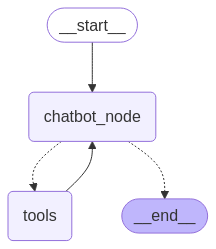

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Let's ask our chatbot to find the "birthday" of the `LangGraph` library.

We will direct the chatbot to the `human_assistance` tool once it has the required information. The arguments `name` and `birthday` are mandatory for the `human_assistance` tool, so they prompt the chatbot to generate proposals for these fields.

In [13]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.


Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================

[{'text': "I'll help you look up when LangGraph was released, and then I'll use the human_assistance tool for review as requested.\n\nFirst, let me search for information about LangGraph's release date:", 'type': 'text'}, {'id': 'toolu_011KHWFxYbFnUvGEF6MPt3dE', 'input': {'query': 'LangGraph release date when was LangGraph released'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_011KHWFxYbFnUvGEF6MPt3dE)
 Call ID: toolu_011KHWFxYbFnUvGEF6MPt3dE
  Args:
    query: LangGraph release date when was LangGraph released


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph Studio: The first agent IDE | by Bhavik Jikadara - Medium", "url": "https://bhavikjikadara.medium.com/langgraph-studio-the-first-agent-ide-468132628274", "content": "LangGraph, launched in January 2023, is a low-level orchestration framework designed for building controllable and complex agentic applications.", "score": 0.80405265}, {"title": "langgraph - PyPI", "url": "https://pypi.org/project/langgraph/", "content": "langgraph · PyPI\nSkip to main content Switch to mobile version\n\nSearch PyPI  Search\n\nHelp\nSponsors\nLog in\nRegister\n\nMenu\n\nHelp\nSponsors\nLog in\nRegister\n\nSearch PyPI  Search\nlanggraph 0.2.70\npip install langgraph Copy PIP instructions\nLatest versionReleased: Feb 6, 2025\nBuilding stateful, multi-actor applications with LLMs\nNavigation\n\nProject description\nRelease history\nDownload files [...] 0.2.20 Sep 13, 2024\n

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================

[{'text': 'Based on my search, I found that LangGraph was launched in January 2023. However, I noticed some inconsistencies in the information, as one source mentions it was launched in January 2023, while the PyPI page shows a version history starting from 2024.\n\nLet me request human assistance to verify this information:', 'type': 'text'}, {'id': 'toolu_019EopKn8bLi3ksvUVY2Mt5p', 'input': {'name': 'LangGraph', 'birthday': 'January 2023'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_019EopKn8bLi3ksvUVY2Mt5p)
 Call ID: toolu_019EopKn8bLi3ksvUVY2Mt5p
  Args:
    name: LangGraph
    birthday: January 2023


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart i

It has stopped due to the `interrupt` in the `human_assistance` tool. In this case, the chatbot, using the search tool, determined that the date of LangGraph is January 2023, but it is not the exact date; it is January 17, 2024, so we can enter it ourselves.

In [14]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': 'Based on my search, I found that LangGraph was launched in January 2023. However, I noticed some inconsistencies in the information, as one source mentions it was launched in January 2023, while the PyPI page shows a version history starting from 2024.\n\nLet me request human assistance to verify this information:', 'type': 'text'}, {'id': 'toolu_019EopKn8bLi3ksvUVY2Mt5p', 'input': {'name': 'LangGraph', 'birthday': 'January 2023'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_019EopKn8bLi3ksvUVY2Mt5p)
 Call ID: toolu_019EopKn8bLi3ksvUVY2Mt5p
  Args:
    name: LangGraph
    birthday: January 2023
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

Thank 

In [15]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

Now the date is correct thanks to human intervention to modify the state values

I rewrite all the code to make it easier to understand

In [1]:
import os
import dotenv

from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langchain_anthropic import ChatAnthropic

dotenv.load_dotenv()
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")
ANTHROPIC_TOKEN = os.getenv("ANTHROPIC_LANGGRAPH_API_KEY")

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

# Tools
wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
search_tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)

@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """
    Request assistance from a human expert. Use this tool ONLY ONCE per conversation.
    After receiving the expert's response, you should provide an elaborated response to the user based on the information received
    based on the information received, without calling this tool again.

    Args:
        query: The query to ask the human expert.

    Returns:
        The response from the human expert.
    """
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )

    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"

    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

tools_list = [search_tool, human_assistance]
tool_node = ToolNode(tools=tools_list)

# Create the LLM
llm = ChatAnthropic(model="claude-3-7-sonnet-20250219", api_key=ANTHROPIC_TOKEN)
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

# Graph
graph_builder = StateGraph(State)

# Nodes
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("chatbot_node", chatbot_function)

# Edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")

# Checkpointer
memory = MemorySaver()

# Compile
graph = graph_builder.compile(checkpointer=memory)

# Visualize
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Error al visualizar el grafo: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`


Let's ask our chatbot to find the "birthday" of the `LangGraph` library.

In [2]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.


Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================

[{'text': "I'll look up when LangGraph was released and then get human verification of the information.", 'type': 'text'}, {'id': 'toolu_017SLLSEnFQZVdBpj85BKHyy', 'input': {'query': 'when was LangGraph released launch date'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_017SLLSEnFQZVdBpj85BKHyy)
 Call ID: toolu_017SLLSEnFQZVdBpj85BKHyy
  Args:
    query: when was LangGraph released launch date


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangChain Introduces LangGraph Studio: The First Agent IDE for ...", "url": "https://www.marktechpost.com/2024/08/03/langchain-introduces-langgraph-studio-the-first-agent-ide-for-visualizing-interacting-with-and-debugging-complex-agentic-applications/", "content": "LangGraph, launched in January 2023, is a highly controllable, low-level orchestration framework for building agentic applications. Since its inception, it has undergone significant improvements, leading to a stable 0.1 release in June. LangGraph features a persistence layer enabling human-in-the-loop interactions and excels at building complex applications requiring domain-specific cognitive architecture.", "score": 0.83742094}, {"title": "LangGraph Studio: The first agent IDE | by Bhavik Jikadara - Medium", "url": "https://bhavikjikadara.medium.com/langgraph-studio-the-first-agent-ide-468132628274"

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================

[{'text': "Based on my search, I found that LangGraph was launched in January 2023. It's described as a low-level orchestration framework for building agentic applications. Since its release, it has seen significant improvements, including a stable 0.1 release in June (presumably 2024).\n\nLet me now get human verification of this information:", 'type': 'text'}, {'id': 'toolu_016h3391yFhtPDhQvwjNgs7W', 'input': {'name': 'Information Verification', 'birthday': 'January 2023'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_016h3391yFhtPDhQvwjNgs7W)
 Call ID: toolu_016h3391yFhtPDhQvwjNgs7W
  Args:
    name: Information Verification
    birthday: January 2023


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


It has stopped due to the `interrupt` in the `human_assistance` tool. In this case, the chatbot, using the search tool, determined that the date of LangGraph is January 2023, but it is not the exact date; it is January 17, 2024, so we can enter it ourselves.

In [3]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "Based on my search, I found that LangGraph was launched in January 2023. It's described as a low-level orchestration framework for building agentic applications. Since its release, it has seen significant improvements, including a stable 0.1 release in June (presumably 2024).\n\nLet me now get human verification of this information:", 'type': 'text'}, {'id': 'toolu_016h3391yFhtPDhQvwjNgs7W', 'input': {'name': 'Information Verification', 'birthday': 'January 2023'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_016h3391yFhtPDhQvwjNgs7W)
 Call ID: toolu_016h3391yFhtPDhQvwjNgs7W
  Args:
    name: Information Verification
    birthday: January 2023
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai M

In [4]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

Now the date is correct thanks to human intervention to modify the state values

### Manual State Update

LangGraph provides a high degree of control over the application state. For example, at any point (even when interrupted), we can manually overwrite a state key using `graph.update_state`:

Let's update the `name` of the state to `LangGraph (library)`.

In [16]:
graph.update_state(config, {"name": "LangGraph (library)"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f010a5a-8a70-618e-8006-89107653db68'}}

If we now check the state with `graph.get_state(config)`, we will see that the `name` has been updated.

In [17]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph (library)', 'birthday': 'Jan 17, 2024'}

Manual status updates will generate a trace in `LangSmith`. They can be used to control `human in the loop` workflows, as can be seen in this [guide](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/edit-graph-state/).

## Checkpoints

In a typical chatbot workflow, the user interacts with the chatbot one or more times to accomplish a task. In the previous sections, we saw how to add memory and a `human in the loop` to be able to verify our graph state and control future responses.

But, maybe a user wants to start from a previous response and wants to `branch` to explore a separate outcome. This is useful for agent applications, when a flow fails they can revert to a previous checkpoint and try another strategy.

`LangGraph` provides this possibility through the `checkpoints`

First we load the values of the API keys

In [1]:
import os
import dotenv

dotenv.load_dotenv()

HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

We create the new state

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

Now we create the graph

In [3]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

We define the `tool` for search

In [4]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
search_tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)

We create a list of `tools`

In [5]:
tools_list = [search_tool]

Next, the `LLM` with the `bind_tools` and we add it to the graph

In [6]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing


# Create the LLM
login(token=HUGGINGFACE_TOKEN)
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    message = llm_with_tools.invoke(state["messages"])
    return {"messages": [message]}

# Add the chatbot node
graph_builder.add_node("chatbot_node", chatbot_function)

We add the `tool` to the graph

In [7]:
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools=tools_list)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot_node", tools_condition)
graph_builder.add_edge("tools", "chatbot_node")

We add the `START` node to the graph

In [8]:
graph_builder.add_edge(START, "chatbot_node")

We create a `checkpointer` [MemorySaver](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver).

In [9]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

We compile the graph with the `checkpointer`

In [10]:
graph = graph_builder.compile(checkpointer=memory)

We represent it graphically

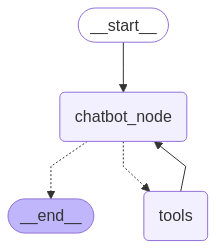

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")

Let's make our graph take a couple of steps. Each step will be saved in the state history.

We make the first call to the model

In [12]:
config = {"configurable": {"thread_id": "1"}}

user_input = (
    "I'm learning LangGraph. "
    "Could you do some research on it for me?"
)

events = graph.stream(
    {"messages": [{"role": "user","content": user_input},],},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (0)
 Call ID: 0
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph Quickstart - GitHub Pages", "url": "https://langchain-ai.github.io/langgraph/tutorials/introduction/", "content": "[](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-9-1)Assistant: LangGraph is a library designed to help build stateful multi-agent applications using language models. It provides tools for creating workflows and state machines to coordinate multiple AI agents or language model interactions. LangGraph is built on top of LangChain, leveraging its components while adding graph-based coordination capabi

And now the second call

In [16]:
user_input = (
    "Ya that's helpful. Maybe I'll "
    "build an autonomous agent with it!"
)

events = graph.stream(
    {"messages": [{"role": "user","content": user_input},],},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (0)
 Call ID: 0
  Args:
    query: LangGraph tutorial build autonomous agent
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph Tutorial: Building LLM Agents with LangChain's ... - Zep", "url": "https://www.getzep.com/ai-agents/langgraph-tutorial", "content": "This article focuses on building agents with LangGraph rather than LangChain. It provides a tutorial for building LangGraph agents, beginning with a discussion of LangGraph and its components. These concepts are reinforced by building a LangGraph agent from scratch and managing conversation memory with LangGraph agents. Finally, we use Zep's long-term memory for egents to create an

Now that we have made two calls to the model, let's check the status history.

In [29]:
to_replay = None
for state in graph.get_state_history(config):
    print(f"Num Messages: {len(state.values["messages"])}, Next: {state.next}, checkpoint id = {state.config["configurable"]['checkpoint_id']}")
    print("-" * 80)

    # Get state when first iteracction us done
    if len(state.next) == 0:
        to_replay = state

Num Messages: 24, Next: (), checkpoint id = 1f027f2f-e5b4-6c84-8018-9fcb33b5f397
--------------------------------------------------------------------------------
Num Messages: 23, Next: ('chatbot_node',), checkpoint id = 1f027f2f-e414-6b0e-8017-3ad465b70767
--------------------------------------------------------------------------------
Num Messages: 22, Next: ('tools',), checkpoint id = 1f027f2f-d382-6692-8016-fcfaf9c9a9f7
--------------------------------------------------------------------------------
Num Messages: 21, Next: ('chatbot_node',), checkpoint id = 1f027f2f-d1cf-6930-8015-f64aa0e6f750
--------------------------------------------------------------------------------
Num Messages: 20, Next: ('tools',), checkpoint id = 1f027f2f-bca9-6164-8014-86452cb10d83
--------------------------------------------------------------------------------
Num Messages: 19, Next: ('chatbot_node',), checkpoint id = 1f027f2f-bac1-6d24-8013-b539f3e4cedb
------------------------------------------------

We have saved in `to_replay` the state of the graph when it gave us the first response, just before introducing the second message. We can revert to a past state and continue the flow from there.

The checkpoint configuration contains the `checkpoint_id`, which is a timestamp of the flow. We can check it to verify that we are in the state we want to be in.

In [30]:
print(to_replay.config)

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f027f2c-8873-61d6-8007-8a1c60438002'}}


If we look at the list of states from before, we see that the ID matches the moment of introducing the second message

Giving this `checkpoint_id` to `LangGraph` loads the state at that moment in the flow. So we create a new message and pass it to the graph

In [31]:
user_input = (
    "Thanks"
)

# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
events = graph.stream({"messages": [{"role": "user","content": user_input},],},
    to_replay.config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Thanks
================================== Ai Message ==================================

You're welcome! If you have any more questions about LangGraph or any other topics, feel free to ask. Happy learning! 🚀


In [32]:
for state in graph.get_state_history(config):
    print(f"Num Messages: {len(state.values["messages"])}, Next: {state.next}, checkpoint id = {state.config["configurable"]['checkpoint_id']}")
    print("-" * 80)

Num Messages: 10, Next: (), checkpoint id = 1f027f43-71ae-67e0-800a-d84a557441fc
--------------------------------------------------------------------------------
Num Messages: 9, Next: ('chatbot_node',), checkpoint id = 1f027f43-5b1f-6ad8-8009-34f409789bc4
--------------------------------------------------------------------------------
Num Messages: 8, Next: ('__start__',), checkpoint id = 1f027f43-5b1b-68a2-8008-fbbcbd1c175e
--------------------------------------------------------------------------------
Num Messages: 24, Next: (), checkpoint id = 1f027f2f-e5b4-6c84-8018-9fcb33b5f397
--------------------------------------------------------------------------------
Num Messages: 23, Next: ('chatbot_node',), checkpoint id = 1f027f2f-e414-6b0e-8017-3ad465b70767
--------------------------------------------------------------------------------
Num Messages: 22, Next: ('tools',), checkpoint id = 1f027f2f-d382-6692-8016-fcfaf9c9a9f7
-------------------------------------------------------------

We can see in the history that the graph executed everything we did first, but then it overwrote the history and ran from an earlier point.

I rewrite the entire graph together

In [1]:
import os
import dotenv

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from huggingface_hub import login
os.environ["LANGCHAIN_TRACING_V2"] = "false"    # Disable LangSmith tracing

from IPython.display import Image, display

class State(TypedDict):
    messages: Annotated[list, add_messages]

dotenv.load_dotenv()
HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_LANGGRAPH")
TAVILY_API_KEY = os.getenv("TAVILY_LANGGRAPH_API_KEY")

# Tools
wrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)
search_tool = TavilySearchResults(api_wrapper=wrapper, max_results=2)
tools_list = [search_tool]
tool_node = ToolNode(tools=tools_list)

# Create the LLM
login(token=HUGGINGFACE_TOKEN)
MODEL = "Qwen/Qwen2.5-72B-Instruct"
model = HuggingFaceEndpoint(
    repo_id=MODEL,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)
# Create the chat model
llm = ChatHuggingFace(llm=model)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools_list)

# Define the chatbot function
def chatbot_function(state: State):
    message = llm_with_tools.invoke(state["messages"])
    return {"messages": [message]}

# Create the graph
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("chatbot_node", chatbot_function)
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge("tools", "chatbot_node")

# Add edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_conditional_edges("chatbot_node", tools_condition)

# Add checkpointer
memory = MemorySaver()

# Compile
graph = graph_builder.compile(checkpointer=memory)

# Visualize
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error al visualizar el grafo: {e}")


Error al visualizar el grafo: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`


We make the first call to the model

In [2]:
config = {"configurable": {"thread_id": "1"}}

user_input = (
    "I'm learning LangGraph. "
    "Could you do some research on it for me?"
)

events = graph.stream(
    {"messages": [{"role": "user","content": user_input},],},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (0)
 Call ID: 0
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "What is LangGraph? - IBM", "url": "https://www.ibm.com/think/topics/langgraph", "content": "LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize large language models (LLMs) in a scalable and efficient manner. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. [.

And now the second call

In [3]:
user_input = (
    "Ya that's helpful. Maybe I'll "
    "build an autonomous agent with it!"
)

events = graph.stream(
    {"messages": [{"role": "user","content": user_input},],},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like an exciting project! Building an autonomous agent using LangGraph can be a rewarding experience. Here are some steps and tips to help you get started:

### 1. **Understand the Basics of LangGraph**
- **Read the Documentation**: Start with the official LangGraph documentation and quickstart guide. This will give you a solid understanding of the framework's capabilities and how to use its tools.
  - **Quickstart Guide**: [LangGraph Quickstart - GitHub Pages](https://langchain-ai.github.io/langgraph/tutorials/introduction/)

### 2. **Set Up Your Development Environment**
- **Install LangChain and LangGraph**: Ensure you have the necessary dependencies installed. LangGraph is built on top of LangChain, so you'll need to set up both.
  ```bash
  pip

We see the status history

In [4]:
to_replay = None
for state in graph.get_state_history(config):
    print(f"Num Messages: {len(state.values["messages"])}, Next: {state.next}, checkpoint id = {state.config["configurable"]['checkpoint_id']}")
    print("-" * 80)

    # Get state when first iteracction us done
    if len(state.next) == 0:
        to_replay = state

Num Messages: 8, Next: (), checkpoint id = 1f03263e-a96c-6446-8008-d2c11df0b6cb
--------------------------------------------------------------------------------
Num Messages: 7, Next: ('chatbot_node',), checkpoint id = 1f03263d-7a35-6660-8007-a37d4b584c88
--------------------------------------------------------------------------------
Num Messages: 6, Next: ('__start__',), checkpoint id = 1f03263d-7a32-624e-8006-6509bbf32ebe
--------------------------------------------------------------------------------
Num Messages: 6, Next: (), checkpoint id = 1f03263d-7a1a-6f36-8005-f10b5d83f22c
--------------------------------------------------------------------------------
Num Messages: 5, Next: ('chatbot_node',), checkpoint id = 1f03263c-c53f-6666-8004-c6d35868dd73
--------------------------------------------------------------------------------
Num Messages: 4, Next: ('tools',), checkpoint id = 1f03263c-b14b-68f8-8003-28558fa38dbc
-----------------------------------------------------------------

In [5]:
print(to_replay.config)

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03263d-7a1a-6f36-8005-f10b5d83f22c'}}


Giving this `checkpoint_id` to `LangGraph` loads the state at that point in the flow. So we create a new message and pass it to the graph.

In [6]:
user_input = (
    "Thanks"
)

# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
events = graph.stream({"messages": [{"role": "user","content": user_input},],},
    to_replay.config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Thanks
================================== Ai Message ==================================

You're welcome! If you have any more questions about LangGraph or any other topic, feel free to reach out. Happy learning! 😊


In [7]:
for state in graph.get_state_history(config):
    print(f"Num Messages: {len(state.values["messages"])}, Next: {state.next}, checkpoint id = {state.config["configurable"]['checkpoint_id']}")
    print("-" * 80)

Num Messages: 8, Next: (), checkpoint id = 1f03263f-fcb9-63a0-8008-e8c4a3fb44f9
--------------------------------------------------------------------------------
Num Messages: 7, Next: ('chatbot_node',), checkpoint id = 1f03263f-eb3b-663c-8007-72da4d16bf64
--------------------------------------------------------------------------------
Num Messages: 6, Next: ('__start__',), checkpoint id = 1f03263f-eb36-6ac4-8006-a2333805d5d6
--------------------------------------------------------------------------------
Num Messages: 8, Next: (), checkpoint id = 1f03263e-a96c-6446-8008-d2c11df0b6cb
--------------------------------------------------------------------------------
Num Messages: 7, Next: ('chatbot_node',), checkpoint id = 1f03263d-7a35-6660-8007-a37d4b584c88
--------------------------------------------------------------------------------
Num Messages: 6, Next: ('__start__',), checkpoint id = 1f03263d-7a32-624e-8006-6509bbf32ebe
-------------------------------------------------------------